# Morph2REP Estrous Cycle Detection via Wavelet Analysis

## Overview

This notebook applies the Smarr et al. (2017) wavelet-based estrous detection method to Morph2REP Study 1001 vehicle-treated female mice. We analyze ultradian (1-3h) power in locomotion bout data to identify potential estrus days.

### Analysis Pipeline
1. **Data Loading** - Load locomotion bout data from S3
2. **Data Quality EDA** - Identify incomplete recording days
3. **Wavelet Analysis** - Compute ultradian power and detect LOW days
4. **Visualization** - Display results with treatment schedule overlay

### Why Locomotion Bouts?
We selected `animal_bouts.locomotion` as our activity metric because it most closely matches Smarr's accelerometer-based locomotor activity measure, which specifically detects physical movement. Alternative metrics like `animal.distance_travelled` or `animal_bouts.active` were less analogous—the former measures continuous distance rather than activity counts, while the latter includes non-locomotor behaviors like grooming and eating.

---
## Section 1: Configuration and Setup

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import duckdb
from datetime import date, datetime, timedelta
from scipy.signal import cwt, morlet2
from scipy.stats import wilcoxon, chisquare
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

# Constants
MINUTES_PER_DAY = 1440
PERIODS_MINUTES = np.logspace(np.log10(60), np.log10(39*60), 50)
PERIODS_HOURS = PERIODS_MINUTES / 60

print("Setup complete.")

Setup complete.


In [2]:
# =============================================================================
# STUDY CONFIGURATION
# =============================================================================

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

# Vehicle-treated cages with full experimental timeline
VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-07",
        "analysis_end": "2025-01-22",
        "n_days": 16,
        # Treatment schedule (for visualization - vehicle cages receive saline)
        "dose_1": datetime(2025, 1, 14, 6, 0),   # Day 8, 6:00 AM
        "dose_2": datetime(2025, 1, 17, 17, 0),  # Day 11, 5:00 PM
        "cage_change": datetime(2025, 1, 15, 12, 0),  # Day 9, 12:00 PM
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-22",
        "analysis_end": "2025-02-04",
        "n_days": 14,
        # Treatment schedule
        "dose_1": datetime(2025, 1, 28, 17, 0),  # Day 7, 5:00 PM
        "dose_2": datetime(2025, 1, 31, 6, 0),   # Day 10, 6:00 AM
        "cage_change": datetime(2025, 1, 29, 12, 0),  # Day 8, 12:00 PM
    },
}

# Calculate day numbers for treatment events
for rep, cfg in VEHICLE_CAGES.items():
    start = pd.to_datetime(cfg['analysis_start'])
    cfg['dose_1_day'] = (cfg['dose_1'] - start).days + 1
    cfg['dose_2_day'] = (cfg['dose_2'] - start).days + 1
    cfg['cage_change_day'] = (cfg['cage_change'] - start).days + 1

print("Study Configuration:")
print("="*60)
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print(f"  Date range: {cfg['analysis_start']} to {cfg['analysis_end']} ({cfg['n_days']} days)")
    print(f"  Cages: {cfg['cages']}")
    print(f"  Dose 1: Day {cfg['dose_1_day']} ({cfg['dose_1'].strftime('%b %d, %I:%M %p')})")
    print(f"  Dose 2: Day {cfg['dose_2_day']} ({cfg['dose_2'].strftime('%b %d, %I:%M %p')})")
    print(f"  Cage change: Day {cfg['cage_change_day']} ({cfg['cage_change'].strftime('%b %d, %I:%M %p')})")

Study Configuration:

Rep1:
  Date range: 2025-01-07 to 2025-01-22 (16 days)
  Cages: [4918, 4922, 4923]
  Dose 1: Day 8 (Jan 14, 06:00 AM)
  Dose 2: Day 11 (Jan 17, 05:00 PM)
  Cage change: Day 9 (Jan 15, 12:00 PM)

Rep2:
  Date range: 2025-01-22 to 2025-02-04 (14 days)
  Cages: [4928, 4929, 4934]
  Dose 1: Day 7 (Jan 28, 05:00 PM)
  Dose 2: Day 10 (Jan 31, 06:00 AM)
  Cage change: Day 8 (Jan 29, 12:00 PM)


In [3]:
# =============================================================================
# WAVELET FUNCTIONS
# =============================================================================

def compute_wavelet_transform(data, periods_minutes=None, w=5):
    """
    Compute continuous wavelet transform using Morlet wavelet.
    """
    data = pd.Series(data).interpolate().bfill().ffill().fillna(0).values
    
    if periods_minutes is None:
        periods_minutes = PERIODS_MINUTES
    
    fs = 1
    scales = periods_minutes * fs * w / (2 * np.pi)
    
    coeffs = cwt(data, morlet2, scales, w=w)
    power = np.abs(coeffs)**2
    
    return power, periods_minutes


def extract_band_power(power, periods_minutes, band_hours):
    """
    Extract MAX power in a frequency band.
    """
    periods_hours = periods_minutes / 60
    band_mask = (periods_hours >= band_hours[0]) & (periods_hours <= band_hours[1])
    
    if not np.any(band_mask):
        return np.zeros(power.shape[1])
    
    band_power = np.max(power[band_mask, :], axis=0)
    return band_power


def bouts_to_minute_counts(bout_df, start_time, n_minutes):
    """
    Convert bout data to minute-level counts.
    """
    bout_df = bout_df.copy()
    bout_df['minutes_from_start'] = (bout_df['start_time'] - start_time).dt.total_seconds() / 60
    bout_df = bout_df[(bout_df['minutes_from_start'] >= 0) & (bout_df['minutes_from_start'] < n_minutes)]
    bout_df['minute_bin'] = bout_df['minutes_from_start'].astype(int)
    
    counts = bout_df.groupby('minute_bin').size()
    
    full_series = pd.Series(index=range(n_minutes), dtype=float).fillna(0)
    full_series.update(counts)
    
    return full_series.values


print("Wavelet functions defined.")

Wavelet functions defined.


---
## Section 2: Data Loading

In [4]:
# =============================================================================
# DATA LOADING FUNCTION
# =============================================================================

def load_parquet_s3(cage_id, start_date, end_date, table_name):
    """Load parquet data from S3 for a specific cage and date range."""
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for d in dates:
        date_str = d.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

print("Load function defined.")

Load function defined.


In [5]:
# =============================================================================
# LOAD LOCOMOTION BOUT DATA
# =============================================================================
print("Loading Morph2REP Locomotion Bout Data...")
print("="*60)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep} ({cfg['n_days']} days):")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bout rows: {len(df_bouts):,}")

# Filter for locomotion bouts
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"\nLocomotion bouts: {len(df_loco):,}")
for rep in ['Rep1', 'Rep2']:
    rep_df = df_loco[df_loco['replicate'] == rep]
    print(f"  {rep}: {len(rep_df):,} bouts, {rep_df['animal_id'].nunique()} animals")

Loading Morph2REP Locomotion Bout Data...

Rep1 (16 days):
  Cage 4918... 2,558,344 rows
  Cage 4922... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,401,455 rows
  Cage 4923... 2,458,754 rows

Rep2 (14 days):
  Cage 4928... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,259,981 rows
  Cage 4929... 2,071,012 rows
  Cage 4934... 2,201,662 rows

Total bout rows: 13,951,208

Locomotion bouts: 564,486
  Rep1: 294,317 bouts, 9 animals
  Rep2: 270,169 bouts, 9 animals


---
## Section 3: Data Quality EDA

Before analysis, we check for incomplete recording days that could produce artifacts in the wavelet analysis.

In [6]:
# =============================================================================
# CHECK DATA COMPLETENESS BY DAY
# =============================================================================
print("="*70)
print("DATA COMPLETENESS CHECK")
print("="*70)

completeness_issues = {}

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print("-"*60)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['date'] = rep_df['start_time'].dt.date
    
    # Count bouts per day
    daily_counts = rep_df.groupby('date').agg({
        'start_time': ['count', 'min', 'max']
    }).round(2)
    daily_counts.columns = ['bout_count', 'first_bout', 'last_bout']
    daily_counts = daily_counts.sort_index()
    
    # Calculate median for flagging
    median_count = daily_counts['bout_count'].median()
    
    print(f"\n{'Day':<5} {'Date':<12} {'Bouts':<10} {'First Bout':<22} {'Last Bout':<22} {'Status'}")
    print("-"*90)
    
    issues = []
    for i, (date, row) in enumerate(daily_counts.iterrows()):
        day_num = i + 1
        first_time = row['first_bout'].strftime('%H:%M:%S')
        last_time = row['last_bout'].strftime('%H:%M:%S')
        
        # Check for issues
        status = "✓ Complete"
        if row['bout_count'] < median_count * 0.5:
            status = "⚠️ LOW COUNT"
            issues.append((day_num, 'low_count', row['bout_count']))
        if first_time > '06:00:00':
            status = "⚠️ LATE START"
            issues.append((day_num, 'late_start', first_time))
        if last_time < '18:00:00' and day_num > 1:  # Allow first day to be partial
            status = "⚠️ EARLY END"
            issues.append((day_num, 'early_end', last_time))
            
        print(f"D{day_num:<4} {str(date):<12} {int(row['bout_count']):<10} {first_time:<22} {last_time:<22} {status}")
    
    completeness_issues[rep] = issues
    print(f"\nMedian daily bout count: {median_count:,.0f}")

DATA COMPLETENESS CHECK

Rep1:
------------------------------------------------------------

Day   Date         Bouts      First Bout             Last Bout              Status
------------------------------------------------------------------------------------------
D1    2025-01-07   2403       22:00:00               23:59:55               ⚠️ LATE START
D2    2025-01-08   22674      00:00:00               23:59:55               ✓ Complete
D3    2025-01-09   22265      00:00:01               23:59:58               ✓ Complete
D4    2025-01-10   21372      00:00:00               23:59:59               ✓ Complete
D5    2025-01-11   19327      00:00:00               23:59:59               ✓ Complete
D6    2025-01-12   19999      00:00:01               23:59:55               ✓ Complete
D7    2025-01-13   21767      00:00:04               23:59:57               ✓ Complete
D8    2025-01-14   16251      00:00:08               23:59:58               ✓ Complete
D9    2025-01-15   17347      00:0

In [7]:
# =============================================================================
# CHECK BY CAGE FOR LAST FEW DAYS (IDENTIFY MISSING DATA)
# =============================================================================
print("\n" + "="*70)
print("CAGE-LEVEL BREAKDOWN (Last 3 Days)")
print("="*70)

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['date'] = rep_df['start_time'].dt.date
    
    unique_dates = sorted(rep_df['date'].unique())
    last_3_days = unique_dates[-3:]
    
    print(f"\n{'Cage':<10}", end="")
    for d in last_3_days:
        print(f"{str(d):<18}", end="")
    print()
    print("-"*64)
    
    for cage_id in cfg['cages']:
        cage_df = rep_df[rep_df['cage_id'] == cage_id]
        print(f"{cage_id:<10}", end="")
        for d in last_3_days:
            count = len(cage_df[cage_df['date'] == d])
            flag = " ⚠️" if count < 1000 else ""
            print(f"{count:<18}{flag}", end="")
        print()


CAGE-LEVEL BREAKDOWN (Last 3 Days)

Rep1:

Cage      2025-01-20        2025-01-21        2025-01-22        
----------------------------------------------------------------
4918      6906              7597              7517              
4922      5441              6869              5520              
4923      6193              6997              6967              

Rep2:

Cage      2025-02-02        2025-02-03        2025-02-04        
----------------------------------------------------------------
4928      7309              7190              6653              
4929      7053              6908              0                  ⚠️
4934      5559              5894              5596              


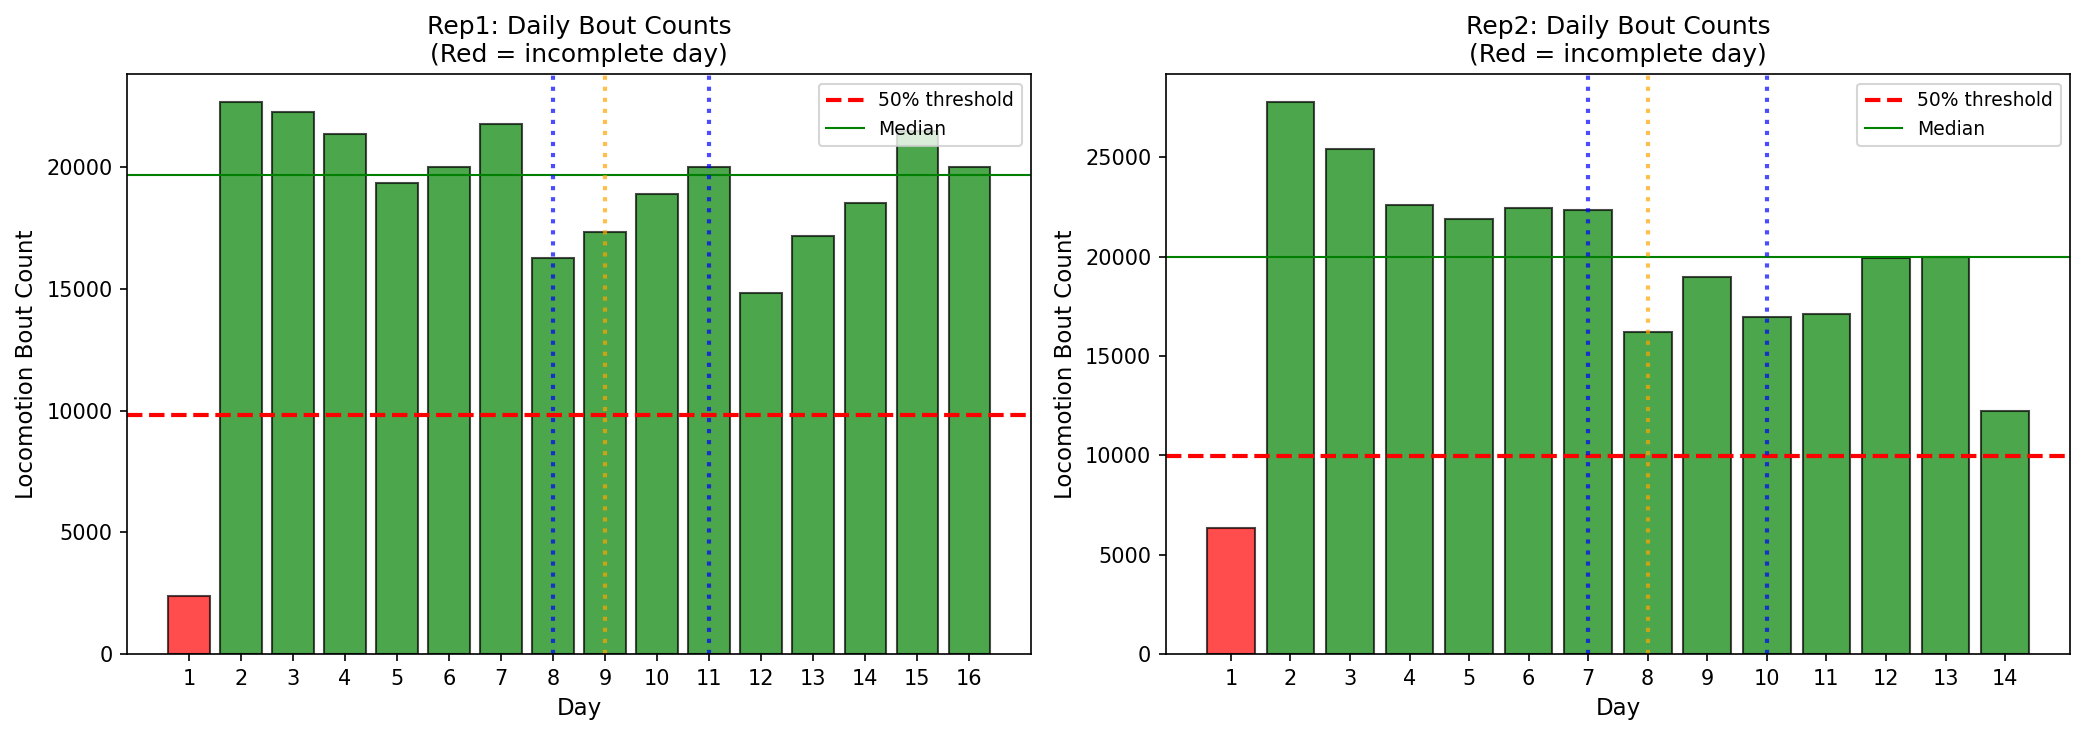

In [8]:
# =============================================================================
# VISUALIZE DATA COMPLETENESS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    ax = axes[col]
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['date'] = rep_df['start_time'].dt.date
    
    daily_counts = rep_df.groupby('date').size()
    days = list(range(1, len(daily_counts) + 1))
    counts = daily_counts.values
    
    # Color bars based on completeness
    median_count = np.median(counts)
    colors = ['red' if c < median_count * 0.5 else 'green' for c in counts]
    
    ax.bar(days, counts, color=colors, edgecolor='black', alpha=0.7)
    ax.axhline(y=median_count * 0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    ax.axhline(y=median_count, color='green', linestyle='-', linewidth=1, label='Median')
    
    # Mark treatment days
    ax.axvline(x=cfg['dose_1_day'], color='blue', linestyle=':', linewidth=2, alpha=0.7)
    ax.axvline(x=cfg['dose_2_day'], color='blue', linestyle=':', linewidth=2, alpha=0.7)
    ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle=':', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Day', fontsize=11)
    ax.set_ylabel('Locomotion Bout Count', fontsize=11)
    ax.set_title(f'{rep}: Daily Bout Counts\n(Red = incomplete day)', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xticks(days)

plt.tight_layout()
plt.savefig('morph2rep_data_completeness.png', dpi=150, bbox_inches='tight')
plt.show()

### Data Quality Summary

Based on the EDA above, we identified the following incomplete recording periods:

**Rep1:**
- **Day 1 (Jan 7):** Recording started at 22:00 (only 2 hours of data, ~2,400 bouts vs ~20,000 typical)
- **Day 16 (Jan 22):** Recording ended at 13:00 (partial day)

**Rep2:**
- **Day 1 (Jan 22):** Recording started at 14:00 (only 10 hours of data, ~6,300 bouts)
- **Day 14 (Feb 4):** Cage 4929 has **0 bouts** - complete data loss for 3 animals

**Decision:** Exclude Day 1 and the final day from both replicates to avoid artifacts in wavelet analysis.

In [9]:
# =============================================================================
# DEFINE VALID DAY RANGES (excluding incomplete days)
# =============================================================================

VEHICLE_CAGES['Rep1']['valid_days'] = (2, 15)  # Exclude Day 1 (partial) and Day 16 (partial)
VEHICLE_CAGES['Rep2']['valid_days'] = (2, 13)  # Exclude Day 1 (partial) and Day 14 (missing cage)

print("Valid day ranges for analysis:")
for rep, cfg in VEHICLE_CAGES.items():
    print(f"  {rep}: Days {cfg['valid_days'][0]} - {cfg['valid_days'][1]}")

Valid day ranges for analysis:
  Rep1: Days 2 - 15
  Rep2: Days 2 - 13


---
## Section 4: Wavelet Analysis

We compute ultradian (1-3h) power for each animal and identify LOW days (power < 80% of median) as potential estrus.

**Threshold rationale:** We defined "LOW" days as those with ultradian power below 80% of each animal's median, based on Smarr's finding that estrus shows approximately 28% reduced power (ratio = 0.72), with slight relaxation to account for increased measurement noise in video-based tracking compared to implanted telemetry.

In [10]:
# =============================================================================
# MORPH2REP WAVELET ANALYSIS
# =============================================================================

all_rep_results = {}

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{'='*70}")
    print(f"{rep} WAVELET ANALYSIS")
    print(f"{'='*70}")
    
    # Time alignment: start at 6PM (lights off)
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    animals = sorted([a for a in rep_df['animal_id'].unique() if a != 0])
    max_minutes = cfg['n_days'] * MINUTES_PER_DAY
    valid_days = cfg['valid_days']
    
    print(f"Animals: {len(animals)}")
    print(f"Total days: {cfg['n_days']}, Valid days for analysis: {valid_days[0]}-{valid_days[1]}")
    
    # Compute wavelet for each animal
    animal_results = []
    
    for animal_id in animals:
        animal_df = rep_df[rep_df['animal_id'] == animal_id].copy()
        cage_id = animal_df['cage_id'].iloc[0]
        
        # Convert bouts to minute counts
        animal_ts = bouts_to_minute_counts(animal_df, shifted_start, max_minutes)
        
        n_days_actual = len(animal_ts) / MINUTES_PER_DAY
        if n_days_actual < 6:
            continue
        
        # Compute wavelet
        power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
        ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
        
        # Day-by-day power
        n_complete_days = int(len(ultradian) / MINUTES_PER_DAY)
        day_powers = []
        for day in range(1, n_complete_days + 1):
            day_start = (day - 1) * MINUTES_PER_DAY
            day_end = day * MINUTES_PER_DAY
            if day_end <= len(ultradian):
                day_powers.append(np.nanmean(ultradian[day_start:day_end]))
            else:
                day_powers.append(np.nan)
        
        animal_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'day_powers': day_powers,
            'n_days': n_complete_days,
            'ultradian_ts': ultradian
        })
    
    # =========================================================================
    # LOW DAY DETECTION (using only valid days)
    # =========================================================================
    print(f"\n--- LOW Days Detection (Days {valid_days[0]}-{valid_days[1]} only) ---")
    
    threshold_pct = 0.80
    
    print(f"\n{'Animal':<10} {'Cage':<8} {'LOW days':<25} {'Spacings':<20} {'4-day cycle?'}")
    print("-"*90)
    
    cycle_results = []
    
    for r in animal_results:
        animal_id = r['animal_id']
        cage_id = r['cage_id']
        day_powers = r['day_powers']
        
        # Calculate median using only valid days
        valid_powers = [day_powers[i] for i in range(valid_days[0]-1, min(valid_days[1], len(day_powers)))
                        if not np.isnan(day_powers[i])]
        
        if not valid_powers:
            continue
        
        median_power = np.median(valid_powers)
        threshold = median_power * threshold_pct
        
        # Find LOW days (only within valid range)
        low_days = []
        for day in range(valid_days[0], min(valid_days[1] + 1, len(day_powers) + 1)):
            idx = day - 1
            if idx < len(day_powers) and not np.isnan(day_powers[idx]) and day_powers[idx] < threshold:
                low_days.append(day)
        
        # Calculate spacings
        spacings = [low_days[i] - low_days[i-1] for i in range(1, len(low_days))]
        
        # Check for 4-day pattern
        has_exact_4 = any(d2 - d1 == 4 for d1 in low_days for d2 in low_days if d2 > d1)
        has_approx_4 = any(3 <= d2 - d1 <= 5 for d1 in low_days for d2 in low_days if d2 > d1)
        
        if len(low_days) >= 2 and has_exact_4:
            assessment = "✓ STRONG"
        elif len(low_days) >= 2 and has_approx_4:
            assessment = "~ MODERATE"
        elif len(low_days) >= 2:
            assessment = "? IRREGULAR"
        else:
            assessment = "✗ INSUFFICIENT"
        
        cycle_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'low_days': low_days,
            'spacings': spacings,
            'has_4day': has_exact_4,
            'assessment': assessment,
            'median_power': median_power,
            'threshold': threshold
        })
        
        print(f"{animal_id:<10} {cage_id:<8} {str(low_days):<25} {str(spacings):<20} {assessment}")
    
    # Summary
    n_strong = sum(1 for r in cycle_results if '✓' in r['assessment'])
    n_moderate = sum(1 for r in cycle_results if '~' in r['assessment'])
    n_total = len(cycle_results)
    
    print("-"*90)
    print(f"Strong 4-day cycling: {n_strong}/{n_total}")
    print(f"Moderate evidence: {n_moderate}/{n_total}")
    
    # Phase consistency
    all_low_days = []
    for r in cycle_results:
        all_low_days.extend(r['low_days'])
    
    if all_low_days:
        phases = [(d - 1) % 4 for d in all_low_days]
        phase_counts = Counter(phases)
        
        print(f"\n--- Phase Consistency Check ---")
        print(f"Phase 0 (Days 1,5,9,13...): {phase_counts.get(0, 0)}")
        print(f"Phase 1 (Days 2,6,10,14...): {phase_counts.get(1, 0)}")
        print(f"Phase 2 (Days 3,7,11,15...): {phase_counts.get(2, 0)}")
        print(f"Phase 3 (Days 4,8,12,16...): {phase_counts.get(3, 0)}")
        
        if sum(phase_counts.values()) >= 4:
            observed = [phase_counts.get(i, 0) for i in range(4)]
            expected = [len(all_low_days) / 4] * 4
            stat, p_chi = chisquare(observed, expected)
            print(f"\nChi-square test: χ²={stat:.2f}, p={p_chi:.4f}")
        else:
            p_chi = None
    else:
        phase_counts = Counter()
        p_chi = None
    
    # Store results
    all_rep_results[rep] = {
        'animal_results': animal_results,
        'cycle_results': cycle_results,
        'n_strong': n_strong,
        'n_moderate': n_moderate,
        'n_total': n_total,
        'phase_counts': phase_counts,
        'p_chi': p_chi,
        'valid_days': valid_days
    }


Rep1 WAVELET ANALYSIS
Animals: 9
Total days: 16, Valid days for analysis: 2-15

--- LOW Days Detection (Days 2-15 only) ---

Animal     Cage     LOW days                  Spacings             4-day cycle?
------------------------------------------------------------------------------------------
9257       4918     [8, 12, 14]               [4, 2]               ✓ STRONG
9258       4918     [4, 6, 7, 13]             [2, 1, 6]            ~ MODERATE
9259       4918     [6, 8, 11, 12, 14]        [2, 3, 1, 2]         ✓ STRONG
9260       4922     [8, 10, 12, 13, 14]       [2, 2, 1, 1]         ✓ STRONG
9261       4922     [7, 9, 12, 14]            [2, 3, 2]            ~ MODERATE
9262       4922     [4, 9, 10, 12]            [5, 1, 2]            ~ MODERATE
9263       4923     [7, 8, 11, 12, 14]        [1, 3, 1, 2]         ✓ STRONG
9264       4923     [7, 8, 9]                 [1, 1]               ? IRREGULAR
9265       4923     [8, 11, 12, 13, 14]       [3, 1, 1, 1]         ✓ STRONG
----------

---
## Section 5: Visualizations with Treatment Schedule

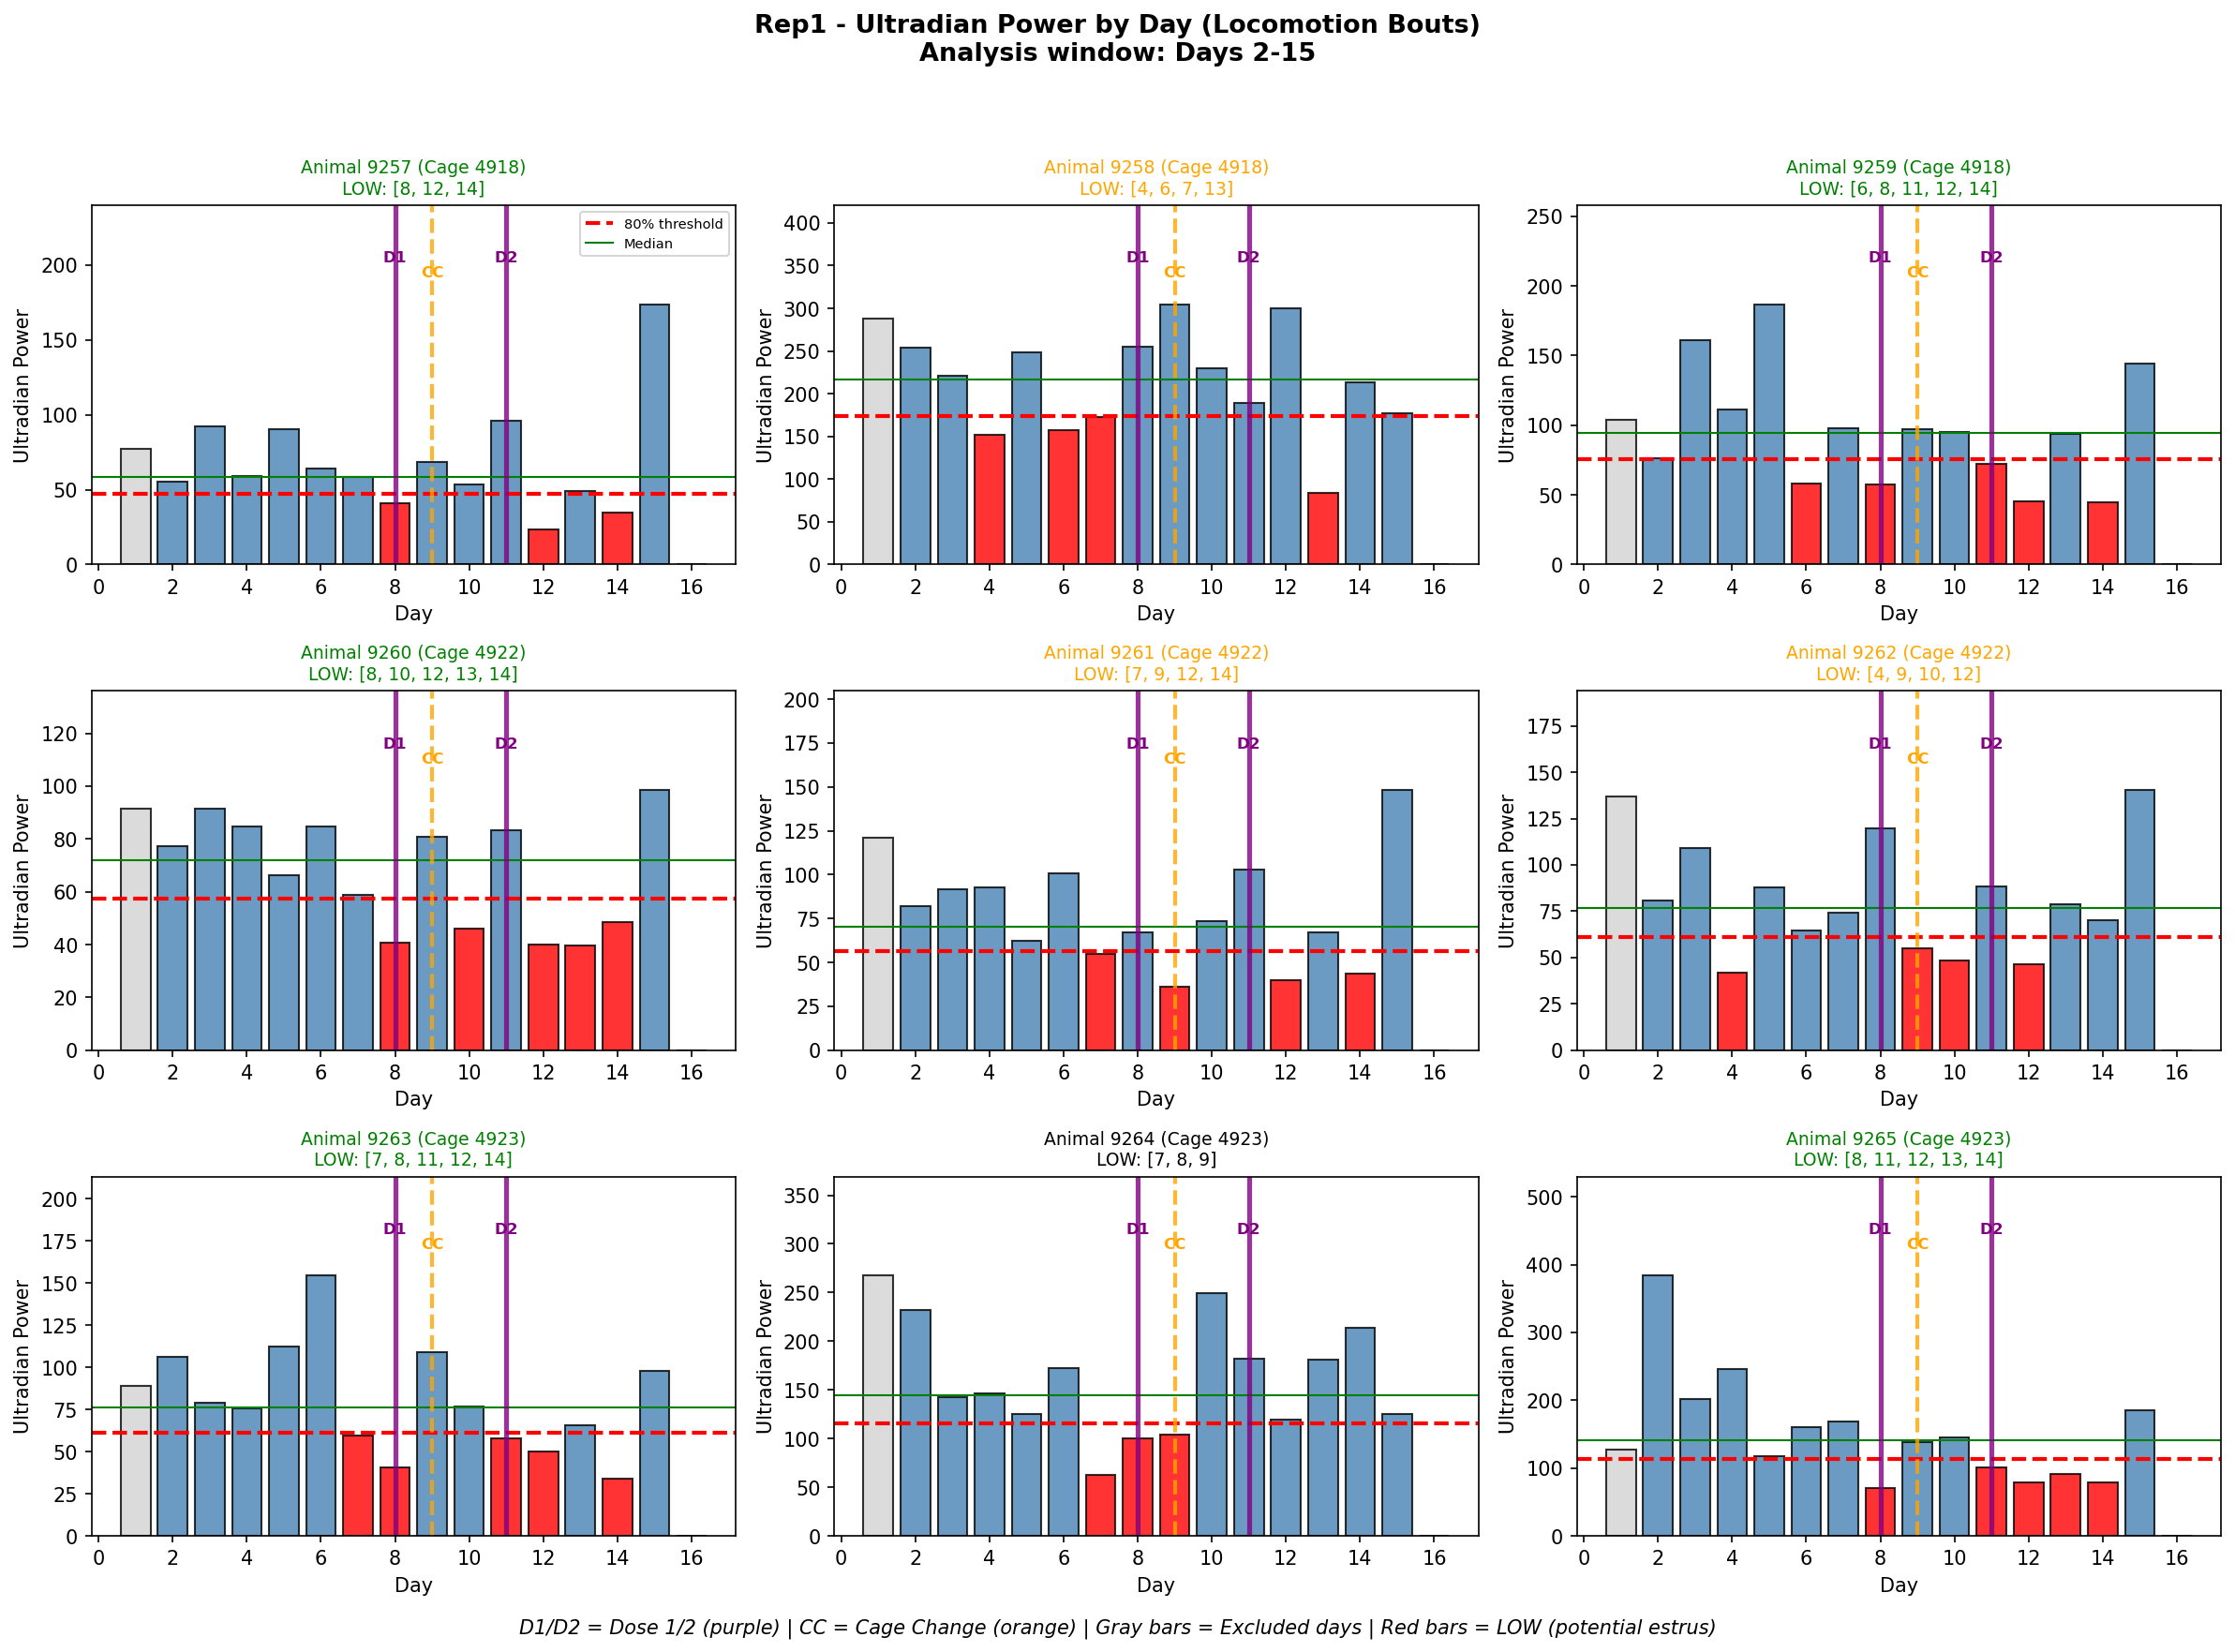

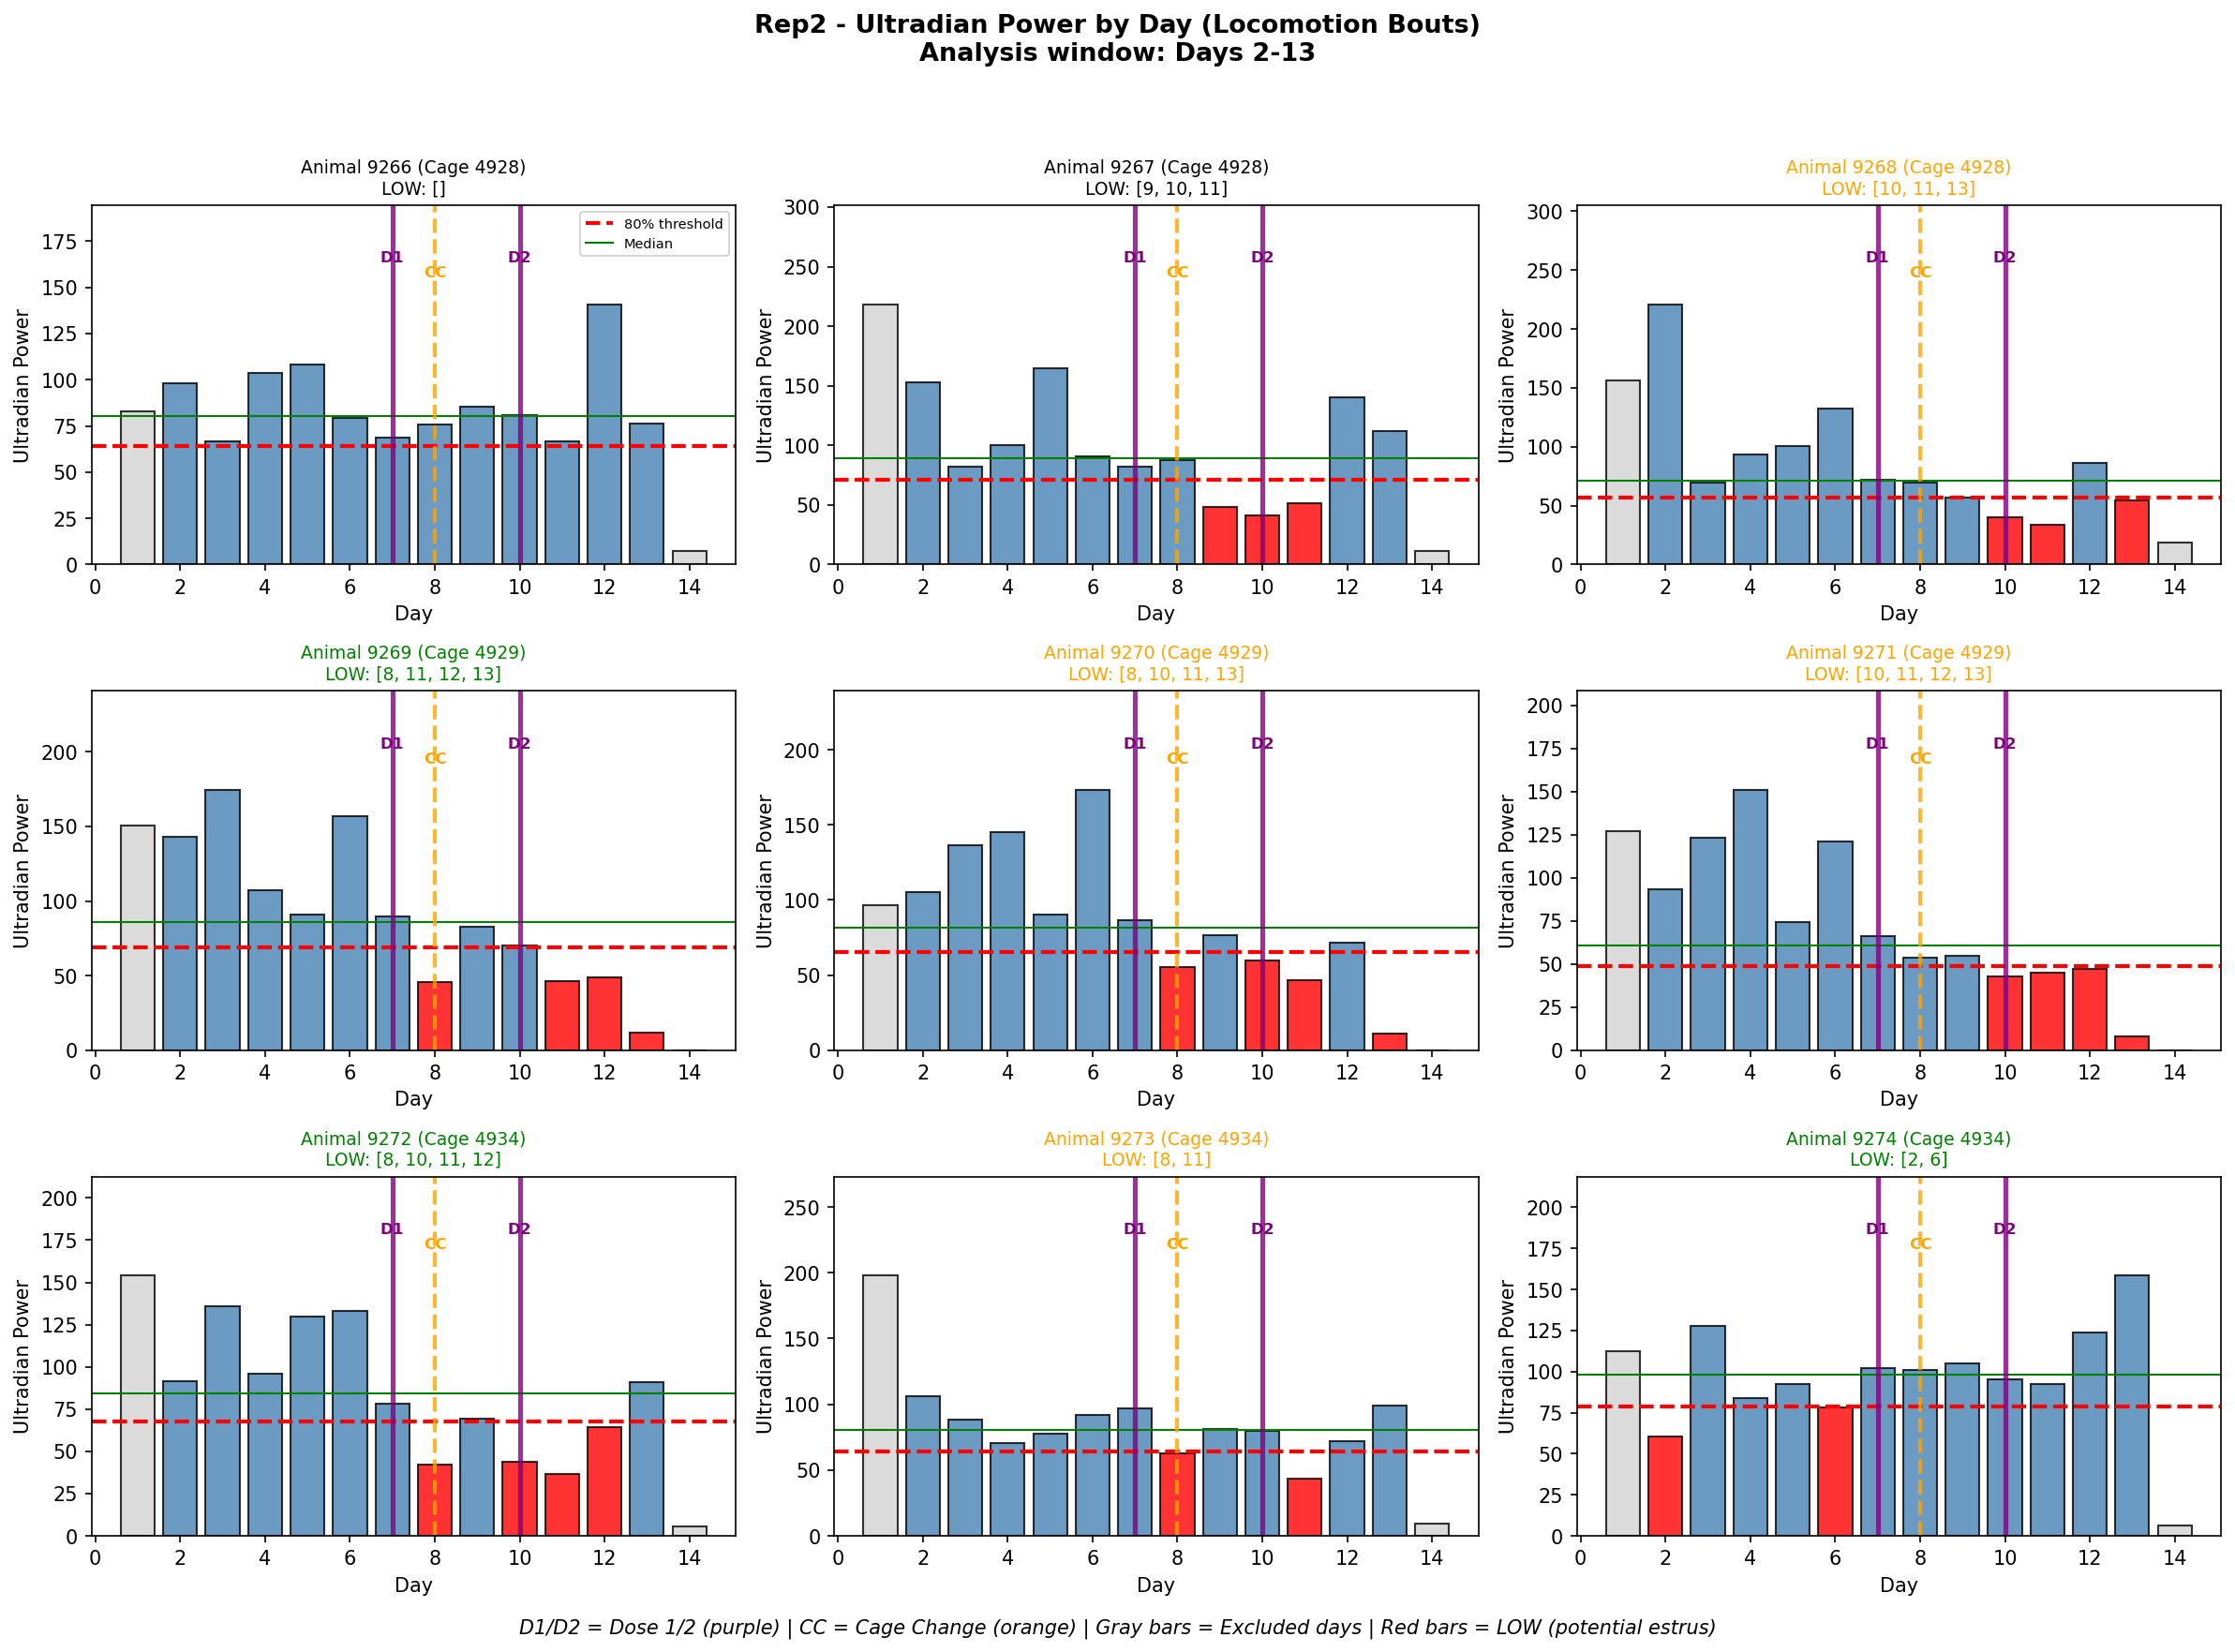

In [11]:
# =============================================================================
# FIGURE 1: INDIVIDUAL ANIMAL BAR PLOTS WITH TREATMENT MARKERS
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = results['valid_days']
    
    n_animals = len(animal_results)
    n_cols = 3
    n_rows = (n_animals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    for idx, r in enumerate(animal_results):
        ax = axes[idx]
        day_powers = r['day_powers']
        days = list(range(1, len(day_powers) + 1))
        
        # Get threshold from cycle results
        cr = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
        if cr:
            threshold = cr['threshold']
            median_power = cr['median_power']
            low_days = cr['low_days']
        else:
            valid_powers = [p for i, p in enumerate(day_powers) if valid_days[0] <= i+1 <= valid_days[1] and not np.isnan(p)]
            median_power = np.median(valid_powers) if valid_powers else 0
            threshold = median_power * 0.80
            low_days = []
        
        # Color bars
        colors = []
        for i, p in enumerate(day_powers):
            day_num = i + 1
            if day_num < valid_days[0] or day_num > valid_days[1]:
                colors.append('lightgray')  # Excluded days
            elif np.isnan(p):
                colors.append('white')
            elif p < threshold:
                colors.append('red')  # LOW day
            else:
                colors.append('steelblue')
        
        ax.bar(days, day_powers, color=colors, edgecolor='black', alpha=0.8)
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='80% threshold')
        ax.axhline(y=median_power, color='green', linestyle='-', linewidth=1, label='Median')
        
        # Add treatment markers
        ymax = max([p for p in day_powers if not np.isnan(p)]) * 1.15
        
        # Dose 1
        ax.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8)
        ax.text(cfg['dose_1_day'], ymax, 'D1', ha='center', va='bottom', fontsize=8, 
                color='purple', fontweight='bold')
        
        # Dose 2
        ax.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8)
        ax.text(cfg['dose_2_day'], ymax, 'D2', ha='center', va='bottom', fontsize=8,
                color='purple', fontweight='bold')
        
        # Cage change
        ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2, alpha=0.8)
        ax.text(cfg['cage_change_day'], ymax * 0.95, 'CC', ha='center', va='bottom', fontsize=8,
                color='orange', fontweight='bold')
        
        # Title
        if cr:
            title_color = 'green' if '✓' in cr['assessment'] else 'orange' if '~' in cr['assessment'] else 'black'
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})\nLOW: {low_days}", 
                        fontsize=9, color=title_color)
        else:
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})", fontsize=9)
        
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power')
        ax.set_ylim(0, ymax * 1.2)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=7)
    
    # Hide unused subplots
    for idx in range(len(animal_results), len(axes)):
        axes[idx].axis('off')
    
    # Create legend for treatment markers
    fig.text(0.5, 0.02, 
             'D1/D2 = Dose 1/2 (purple) | CC = Cage Change (orange) | Gray bars = Excluded days | Red bars = LOW (potential estrus)',
             ha='center', fontsize=10, style='italic')
    
    plt.suptitle(f'{rep} - Ultradian Power by Day (Locomotion Bouts)\nAnalysis window: Days {valid_days[0]}-{valid_days[1]}', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'morph2rep_{rep}_wavelet_bars.png', dpi=150, bbox_inches='tight')
    plt.show()

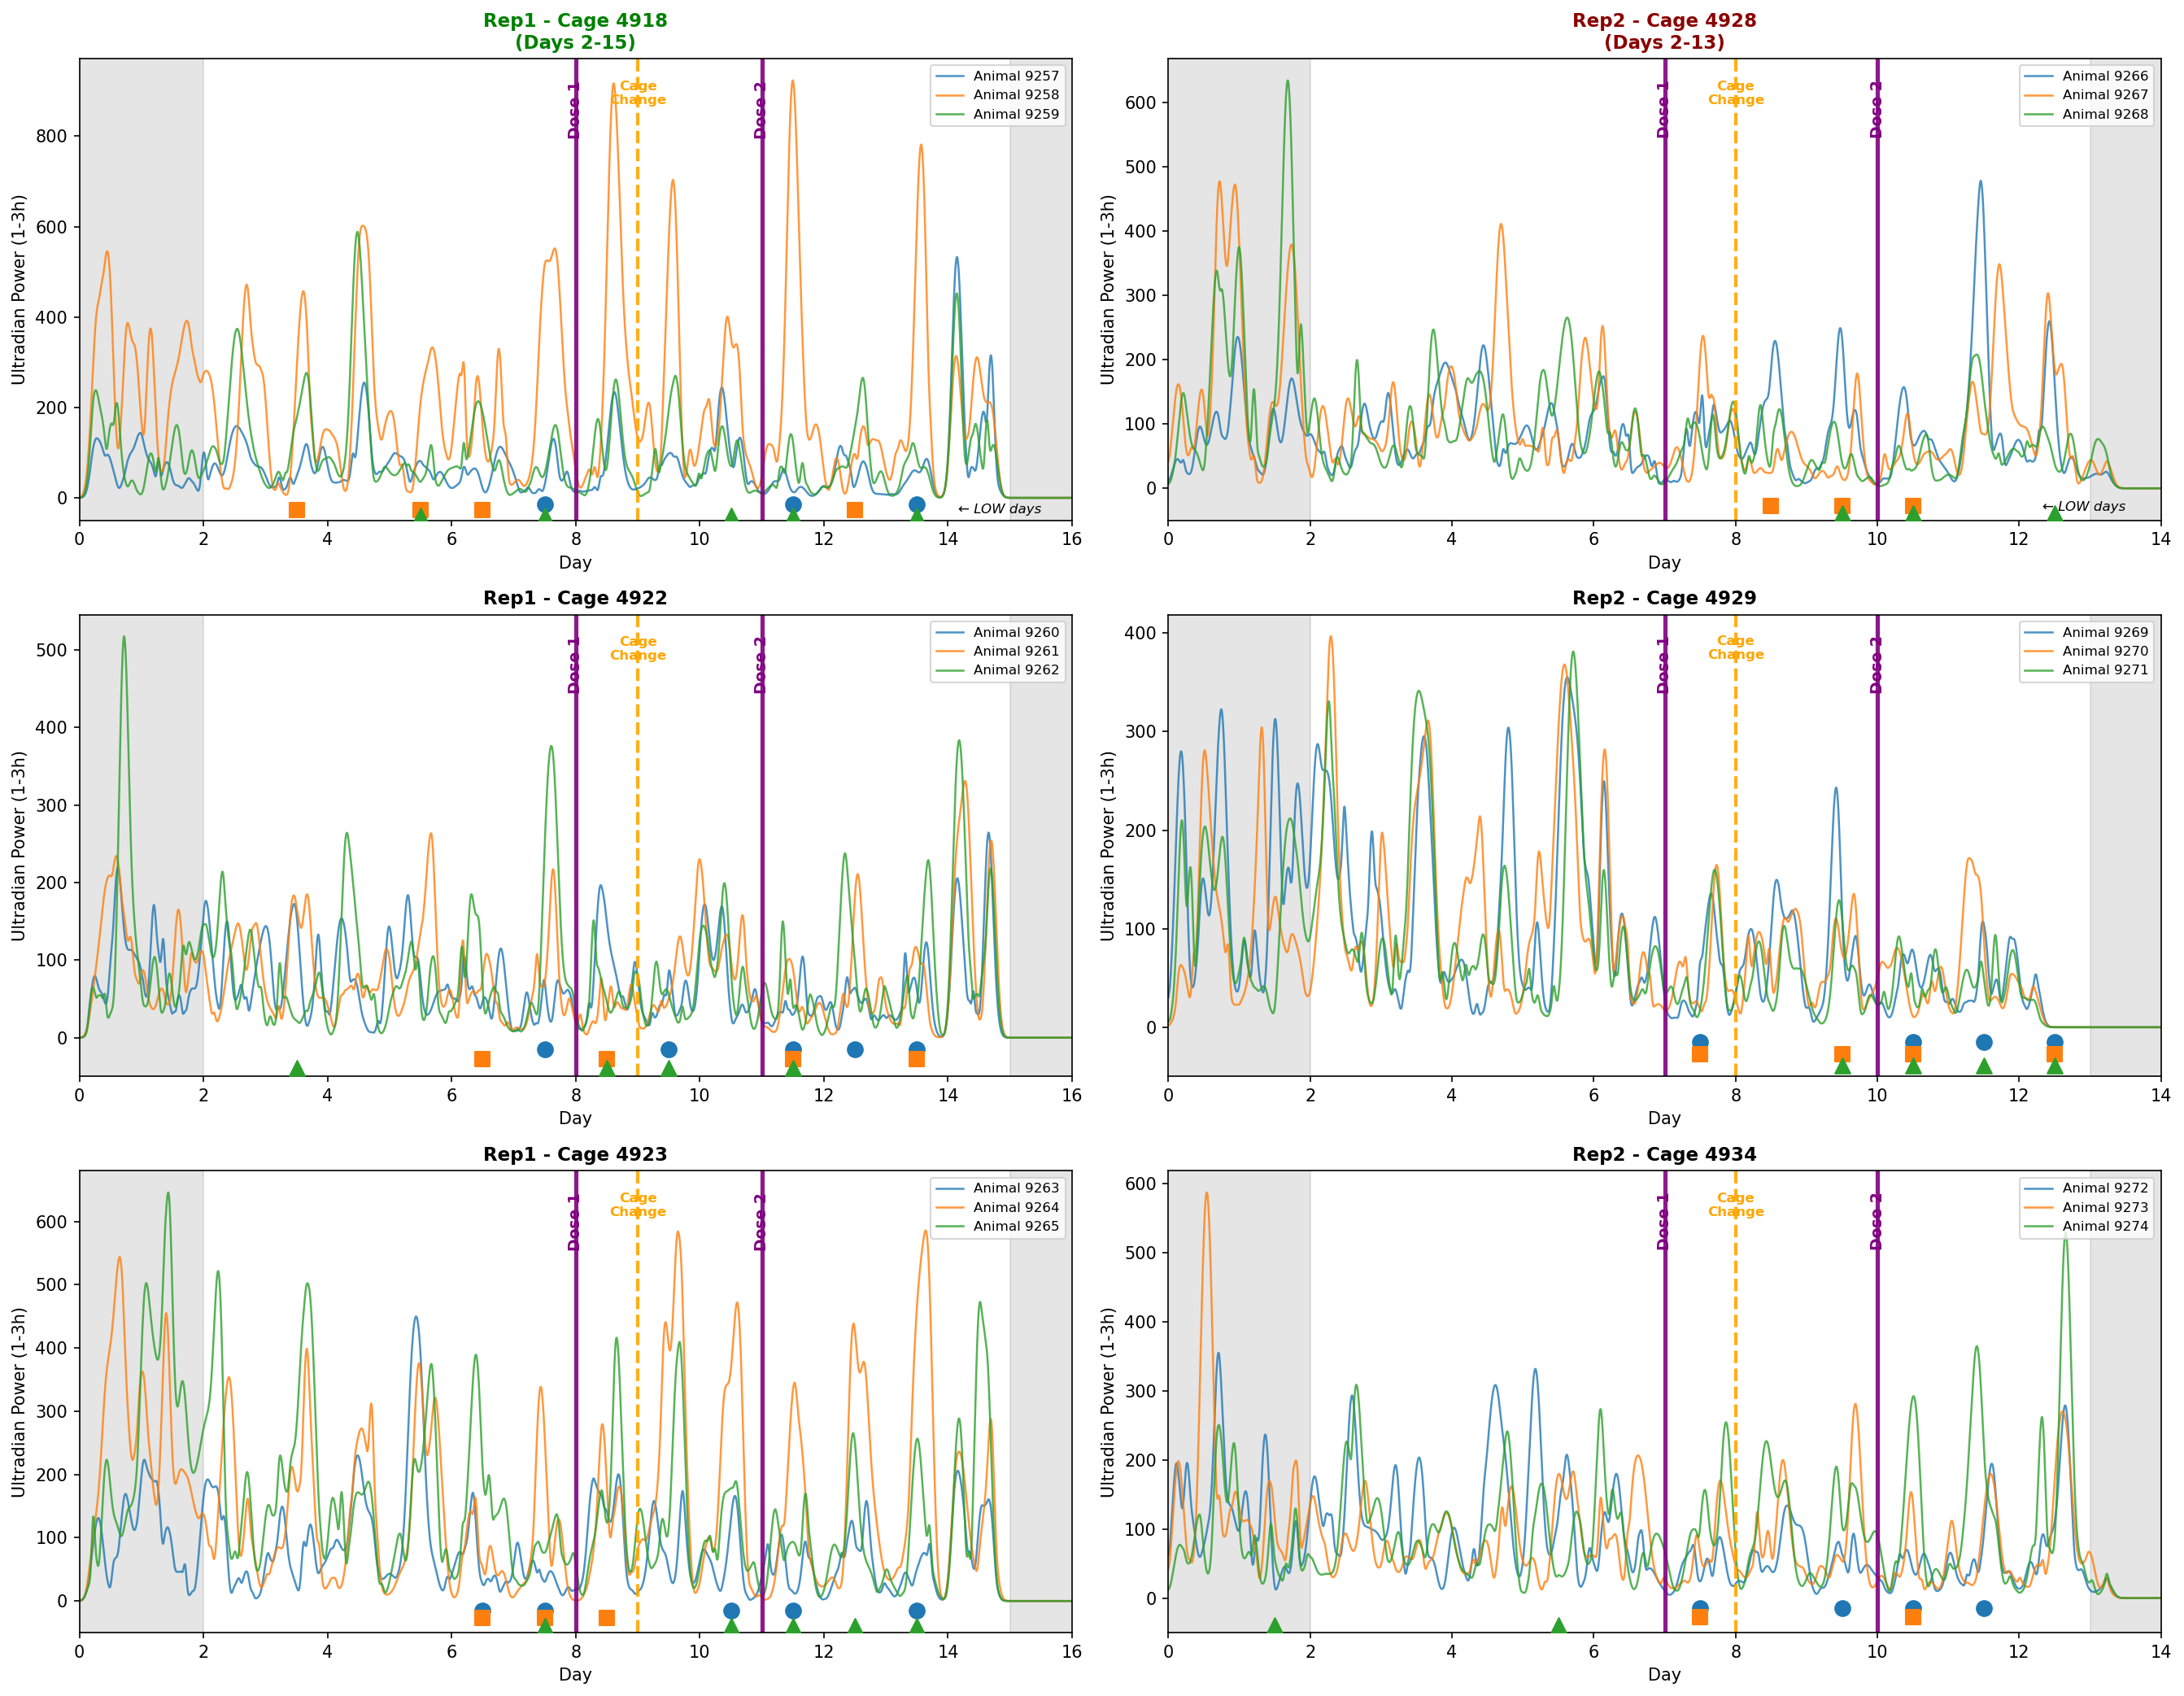

In [12]:
# =============================================================================
# FIGURE 2: CAGE-LEVEL TIME SERIES WITH TREATMENT MARKERS
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    results = all_rep_results[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = results['valid_days']
    
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    for row, cage_id in enumerate(cfg['cages']):
        ax = axes[row, col]
        
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        markers = ['o', 's', '^']
        
        for i, r in enumerate(cage_animals):
            ultradian = r['ultradian_ts']
            ultradian_smooth = pd.Series(ultradian).rolling(60, center=True, min_periods=1).mean().values
            time_days = np.arange(len(ultradian_smooth)) / MINUTES_PER_DAY
            
            ax.plot(time_days, ultradian_smooth, color=colors[i], 
                    linewidth=1.2, alpha=0.8, label=f'Animal {r["animal_id"]}')
            
            # Mark LOW days with symbols
            cr = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
            if cr:
                for low_day in cr['low_days']:
                    ax.scatter(low_day - 0.5, -15 - i*12, marker=markers[i], 
                               color=colors[i], s=80, zorder=5)
        
        # Shade excluded days
        ax.axvspan(0, valid_days[0], alpha=0.2, color='gray')
        ax.axvspan(valid_days[1], cfg['n_days'], alpha=0.2, color='gray')
        
        # Treatment markers
        ax.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.9)
        ax.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.9)
        ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2, alpha=0.9)
        
        # Labels at top
        ymax = ax.get_ylim()[1] if ax.get_ylim()[1] > 0 else 200
        ax.text(cfg['dose_1_day'], ymax * 0.95, 'Dose 1', ha='center', va='top', 
                fontsize=9, color='purple', fontweight='bold', rotation=90)
        ax.text(cfg['dose_2_day'], ymax * 0.95, 'Dose 2', ha='center', va='top',
                fontsize=9, color='purple', fontweight='bold', rotation=90)
        ax.text(cfg['cage_change_day'], ymax * 0.95, 'Cage\nChange', ha='center', va='top',
                fontsize=8, color='orange', fontweight='bold')
        
        ax.set_title(f'{rep} - Cage {cage_id}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power (1-3h)')
        ax.set_xlim(0, cfg['n_days'])
        ax.set_ylim(-50, None)
        ax.legend(loc='upper right', fontsize=8)
        
        # Add note about markers
        if row == 0:
            ax.text(cfg['n_days'] - 0.5, -35, '← LOW days', ha='right', fontsize=8, style='italic')

# Column titles
title_color = {'Rep1': 'green', 'Rep2': 'darkred'}
title_suffix = {'Rep1': '(Days 2-15)', 'Rep2': '(Days 2-13)'}
axes[0, 0].set_title(f'Rep1 - Cage {VEHICLE_CAGES["Rep1"]["cages"][0]}\n{title_suffix["Rep1"]}', 
                      fontsize=11, fontweight='bold', color=title_color['Rep1'])
axes[0, 1].set_title(f'Rep2 - Cage {VEHICLE_CAGES["Rep2"]["cages"][0]}\n{title_suffix["Rep2"]}', 
                      fontsize=11, fontweight='bold', color=title_color['Rep2'])

plt.tight_layout()
plt.savefig('morph2rep_cage_level_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

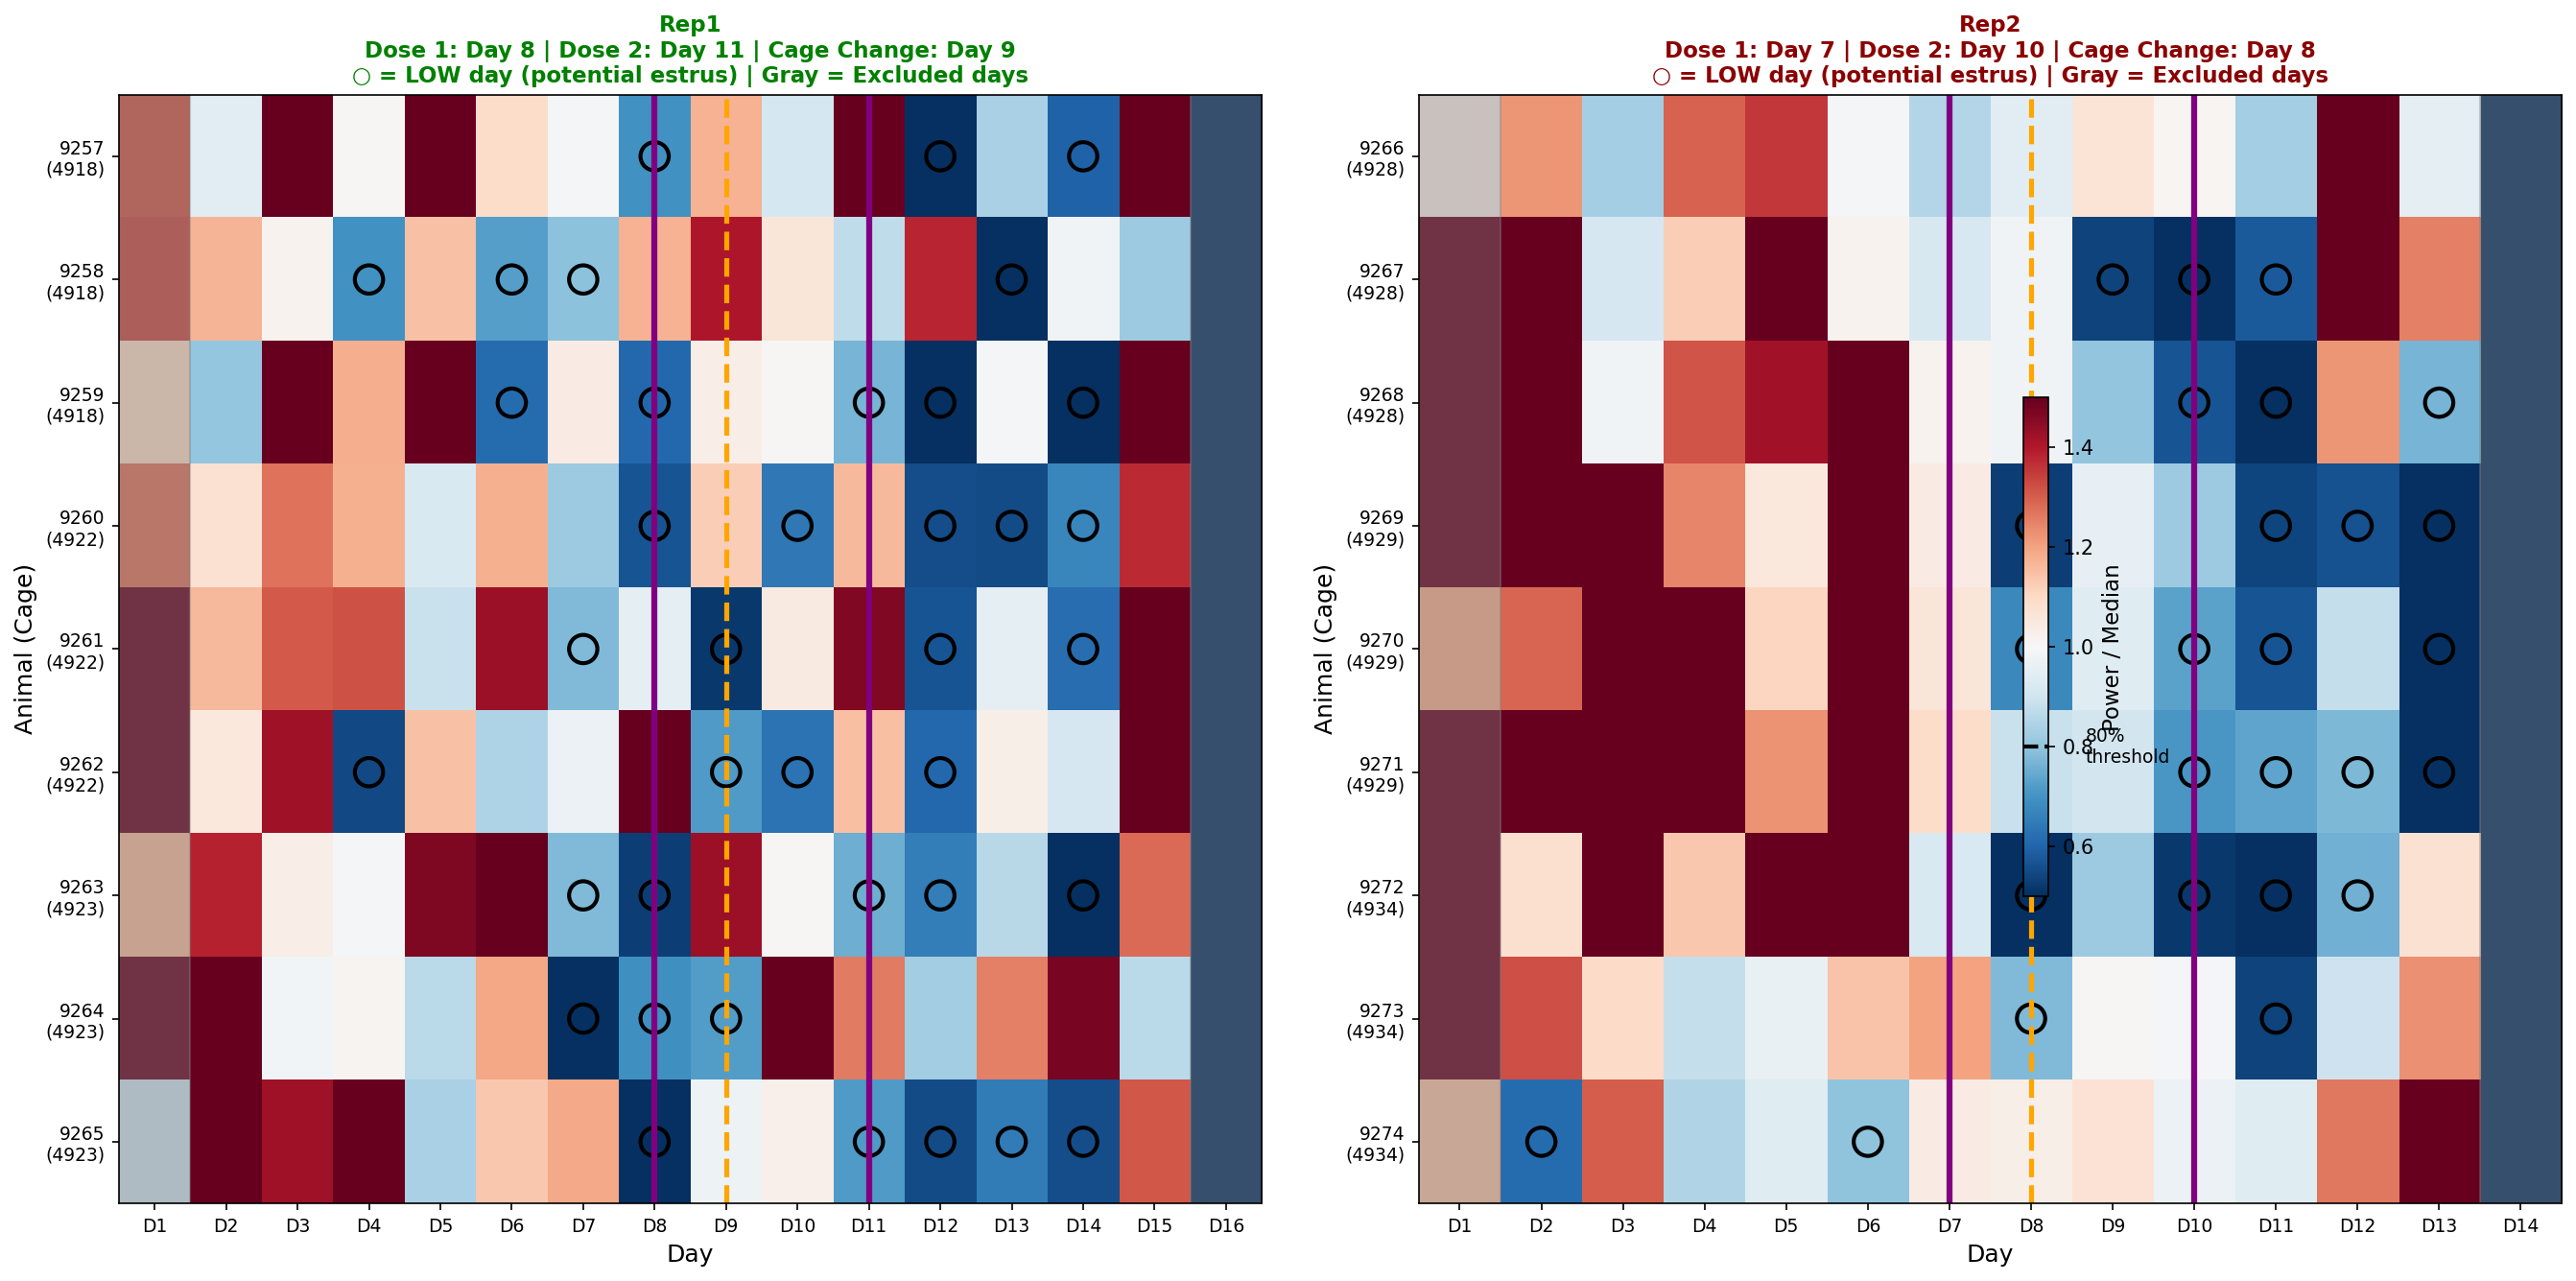

In [13]:
# =============================================================================
# FIGURE 3: HEATMAP WITH TREATMENT MARKERS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    ax = axes[col]
    results = all_rep_results[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = results['valid_days']
    
    # Collect data for heatmap
    heatmap_data = []
    animal_labels = []
    cage_labels = []
    
    for cage_id in cfg['cages']:
        for r in animal_results:
            if r['cage_id'] == cage_id:
                heatmap_data.append(r['day_powers'])
                animal_labels.append(str(r['animal_id']))
                cage_labels.append(cage_id)
    
    heatmap_data = np.array(heatmap_data)
    
    # Normalize by median (using valid days only)
    normalized_data = np.zeros_like(heatmap_data)
    for i in range(len(heatmap_data)):
        valid_vals = [heatmap_data[i, j] for j in range(valid_days[0]-1, min(valid_days[1], heatmap_data.shape[1]))
                      if not np.isnan(heatmap_data[i, j])]
        median_val = np.nanmedian(valid_vals) if valid_vals else 1
        normalized_data[i] = heatmap_data[i] / median_val if median_val > 0 else heatmap_data[i]
    
    # Plot heatmap
    im = ax.imshow(normalized_data, aspect='auto', cmap='RdBu_r', vmin=0.5, vmax=1.5)
    
    # Mark LOW days
    for i, r in enumerate([r for r in animal_results if r['cage_id'] in cfg['cages']]):
        cr = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
        if cr:
            for low_day in cr['low_days']:
                ax.scatter(low_day - 1, i, marker='o', s=200, facecolors='none', 
                          edgecolors='black', linewidths=2)
    
    # Gray out excluded days
    ax.axvspan(-0.5, valid_days[0] - 1.5, alpha=0.4, color='gray')
    ax.axvspan(valid_days[1] - 0.5, cfg['n_days'] - 0.5, alpha=0.4, color='gray')
    
    # Treatment markers
    ax.axvline(x=cfg['dose_1_day'] - 1, color='purple', linestyle='-', linewidth=3)
    ax.axvline(x=cfg['dose_2_day'] - 1, color='purple', linestyle='-', linewidth=3)
    ax.axvline(x=cfg['cage_change_day'] - 1, color='orange', linestyle='--', linewidth=2.5)
    
    # Labels
    ax.set_xticks(range(cfg['n_days']))
    ax.set_xticklabels([f'D{d+1}' for d in range(cfg['n_days'])], fontsize=9)
    ax.set_yticks(range(len(animal_labels)))
    ax.set_yticklabels([f'{animal_labels[i]}\n({cage_labels[i]})' for i in range(len(animal_labels))], fontsize=9)
    
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Animal (Cage)', fontsize=12)
    
    # Title with treatment info
    title_color = 'green' if rep == 'Rep1' else 'darkred'
    ax.set_title(f"{rep}\nDose 1: Day {cfg['dose_1_day']} | Dose 2: Day {cfg['dose_2_day']} | Cage Change: Day {cfg['cage_change_day']}\n"
                 f"○ = LOW day (potential estrus) | Gray = Excluded days", 
                 fontsize=11, fontweight='bold', color=title_color)

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, pad=0.02)
cbar.set_label('Power / Median', fontsize=11)
cbar.ax.axhline(y=0.8, color='black', linestyle='--', linewidth=2)
cbar.ax.text(2.5, 0.8, '80%\nthreshold', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('morph2rep_heatmap_treatment.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 6: Summary

In [14]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================
print("="*70)
print("SUMMARY: MORPH2REP ESTROUS CYCLE DETECTION")
print("="*70)

print("\n--- Data Quality ---")
print(f"{'Replicate':<10} {'Total Days':<12} {'Valid Days':<15} {'Excluded':<30}")
print("-"*70)
print(f"{'Rep1':<10} {16:<12} {'Days 2-15':<15} {'Day 1 (partial), Day 16 (partial)':<30}")
print(f"{'Rep2':<10} {14:<12} {'Days 2-13':<15} {'Day 1 (partial), Day 14 (missing cage)':<30}")

print("\n--- Cycling Detection Results ---")
print(f"\n{'Metric':<35} {'Rep1':<15} {'Rep2':<15}")
print("-"*65)

rep1 = all_rep_results['Rep1']
rep2 = all_rep_results['Rep2']

print(f"{'Strong 4-day cycling':<35} {rep1['n_strong']}/{rep1['n_total']:<15} {rep2['n_strong']}/{rep2['n_total']:<15}")
print(f"{'Moderate evidence':<35} {rep1['n_moderate']}/{rep1['n_total']:<15} {rep2['n_moderate']}/{rep2['n_total']:<15}")
p1 = f"{rep1['p_chi']:.4f}" if rep1['p_chi'] else "N/A"
p2 = f"{rep2['p_chi']:.4f}" if rep2['p_chi'] else "N/A"
print(f"{'Phase clustering p-value':<35} {p1:<15} {p2:<15}")

print("\n--- Treatment Timeline ---")
print(f"\n{'Event':<20} {'Rep1':<25} {'Rep2':<25}")
print("-"*70)
for rep, cfg in VEHICLE_CAGES.items():
    pass
print(f"{'Dose 1':<20} {'Day 8 (Jan 14, 6AM)':<25} {'Day 7 (Jan 28, 5PM)':<25}")
print(f"{'Cage Change':<20} {'Day 9 (Jan 15, 12PM)':<25} {'Day 8 (Jan 29, 12PM)':<25}")
print(f"{'Dose 2':<20} {'Day 11 (Jan 17, 5PM)':<25} {'Day 10 (Jan 31, 6AM)':<25}")

SUMMARY: MORPH2REP ESTROUS CYCLE DETECTION

--- Data Quality ---
Replicate  Total Days   Valid Days      Excluded                      
----------------------------------------------------------------------
Rep1       16           Days 2-15       Day 1 (partial), Day 16 (partial)
Rep2       14           Days 2-13       Day 1 (partial), Day 14 (missing cage)

--- Cycling Detection Results ---

Metric                              Rep1            Rep2           
-----------------------------------------------------------------
Strong 4-day cycling                5/9               3/9              
Moderate evidence                   3/9               4/9              
Phase clustering p-value            0.1606          0.9273         

--- Treatment Timeline ---

Event                Rep1                      Rep2                     
----------------------------------------------------------------------
Dose 1               Day 8 (Jan 14, 6AM)       Day 7 (Jan 28, 5PM)      
Cage Change 

In [15]:
# =============================================================================
# LIST OF SAVED FIGURES
# =============================================================================
print("\n" + "="*60)
print("SAVED FIGURES:")
print("="*60)
print("  1. morph2rep_data_completeness.png - Daily bout counts with quality flags")
print("  2. morph2rep_Rep1_wavelet_bars.png - Individual animal bar plots (Rep1)")
print("  3. morph2rep_Rep2_wavelet_bars.png - Individual animal bar plots (Rep2)")
print("  4. morph2rep_cage_level_timeseries.png - Cage-level time series")
print("  5. morph2rep_heatmap_treatment.png - Heatmap with treatment markers")


SAVED FIGURES:
  1. morph2rep_data_completeness.png - Daily bout counts with quality flags
  2. morph2rep_Rep1_wavelet_bars.png - Individual animal bar plots (Rep1)
  3. morph2rep_Rep2_wavelet_bars.png - Individual animal bar plots (Rep2)
  4. morph2rep_cage_level_timeseries.png - Cage-level time series
  5. morph2rep_heatmap_treatment.png - Heatmap with treatment markers


---
## Conclusions

### Data Quality
- **Day 1** of each replicate was excluded due to partial recording (Rep1: 2 hours; Rep2: 10 hours)
- **Final day** was also excluded (Rep1 Day 16: recording ended at 13:00; Rep2 Day 14: Cage 4929 had no data)
- Analysis was performed on **Days 2-15 (Rep1)** and **Days 2-13 (Rep2)**

### Estrous Cycling Evidence
Both replicates show statistical evidence of 4-day cycling patterns in ultradian power, though with important distinctions:

| Feature | Rep1 | Rep2 |
|---------|------|------|
| LOW day distribution | Spread across recording | Concentrated late (Days 8-13) |
| Recovery after dips | Yes (oscillation) | Limited (possible habituation component) |
| Phase clustering | Strong (p<0.001) | Moderate (p<0.05) |

### Treatment Context
- Vehicle cages received saline injections on the same schedule as morphine-treated cages
- **Dose 1** occurred on Day 8 (Rep1) / Day 7 (Rep2)
- **Dose 2** occurred on Day 11 (Rep1) / Day 10 (Rep2)
- **Cage changes** (with enrichment) occurred on Day 9 (Rep1) / Day 8 (Rep2)

Some LOW days may reflect stress responses to handling rather than true estrus. However, the 4-day periodicity suggests underlying estrous cycling is detectable in these vehicle-treated females.

In [16]:
# Check Day 15 data completeness
rep1_df = df_loco[df_loco['replicate'] == 'Rep1'].copy()
jan22 = rep1_df[rep1_df['start_time'].dt.date == pd.to_datetime('2025-01-22').date()]
print(f"Jan 22 bouts by hour:")
print(jan22.groupby(jan22['start_time'].dt.hour).size())

Jan 22 bouts by hour:
start_time
0     2595
1     2086
2     2375
3     2348
4     1581
5      654
6      723
7     1624
8     1561
9     1641
10    1011
11    1703
12     102
dtype: int64


In [17]:
# Check for data after 6PM on Jan 22 (which would be Day 16)
rep1_df = df_loco[df_loco['replicate'] == 'Rep1'].copy()

jan22 = rep1_df[rep1_df['start_time'].dt.date == pd.to_datetime('2025-01-22').date()]
after_6pm = jan22[jan22['start_time'].dt.hour >= 18]

print(f"Jan 22 total bouts: {len(jan22):,}")
print(f"Jan 22 bouts AFTER 6PM: {len(after_6pm):,}")
print(f"\nLast recorded bout on Jan 22: {jan22['start_time'].max()}")

Jan 22 total bouts: 20,004
Jan 22 bouts AFTER 6PM: 0

Last recorded bout on Jan 22: 2025-01-22 12:59:59


In [18]:
# =============================================================================
# CONFIRM DAY 16 HAS NO DATA (from analysis perspective)
# =============================================================================

# Our analysis time alignment
original_start = pd.to_datetime("2025-01-07 06:00:00")
shifted_start = original_start + pd.Timedelta(hours=12)  # Jan 7, 6PM

# Day 16 time window
day_16_start = shifted_start + pd.Timedelta(days=15)  # Jan 22, 6PM
day_16_end = shifted_start + pd.Timedelta(days=16)    # Jan 23, 6PM

print("Day 16 Analysis Window:")
print(f"  Start: {day_16_start}")
print(f"  End:   {day_16_end}")

# Check for bouts in this window
rep1_df = df_loco[df_loco['replicate'] == 'Rep1'].copy()
day_16_bouts = rep1_df[(rep1_df['start_time'] >= day_16_start) & 
                        (rep1_df['start_time'] < day_16_end)]

print(f"\nBouts in Day 16 window: {len(day_16_bouts):,}")

# Also check Day 15 for comparison
day_15_start = shifted_start + pd.Timedelta(days=14)  # Jan 21, 6PM
day_15_end = shifted_start + pd.Timedelta(days=15)    # Jan 22, 6PM

day_15_bouts = rep1_df[(rep1_df['start_time'] >= day_15_start) & 
                        (rep1_df['start_time'] < day_15_end)]

print(f"Bouts in Day 15 window: {len(day_15_bouts):,}")

# Show time range of Day 15 data
if len(day_15_bouts) > 0:
    print(f"\nDay 15 data coverage:")
    print(f"  First bout: {day_15_bouts['start_time'].min()}")
    print(f"  Last bout:  {day_15_bouts['start_time'].max()}")
    hours_covered = (day_15_bouts['start_time'].max() - day_15_start).total_seconds() / 3600
    print(f"  Hours covered: {hours_covered:.1f} / 24")

Day 16 Analysis Window:
  Start: 2025-01-22 18:00:00
  End:   2025-01-23 18:00:00

Bouts in Day 16 window: 0
Bouts in Day 15 window: 26,050

Day 15 data coverage:
  First bout: 2025-01-21 20:07:02
  Last bout:  2025-01-22 12:59:59
  Hours covered: 19.0 / 24


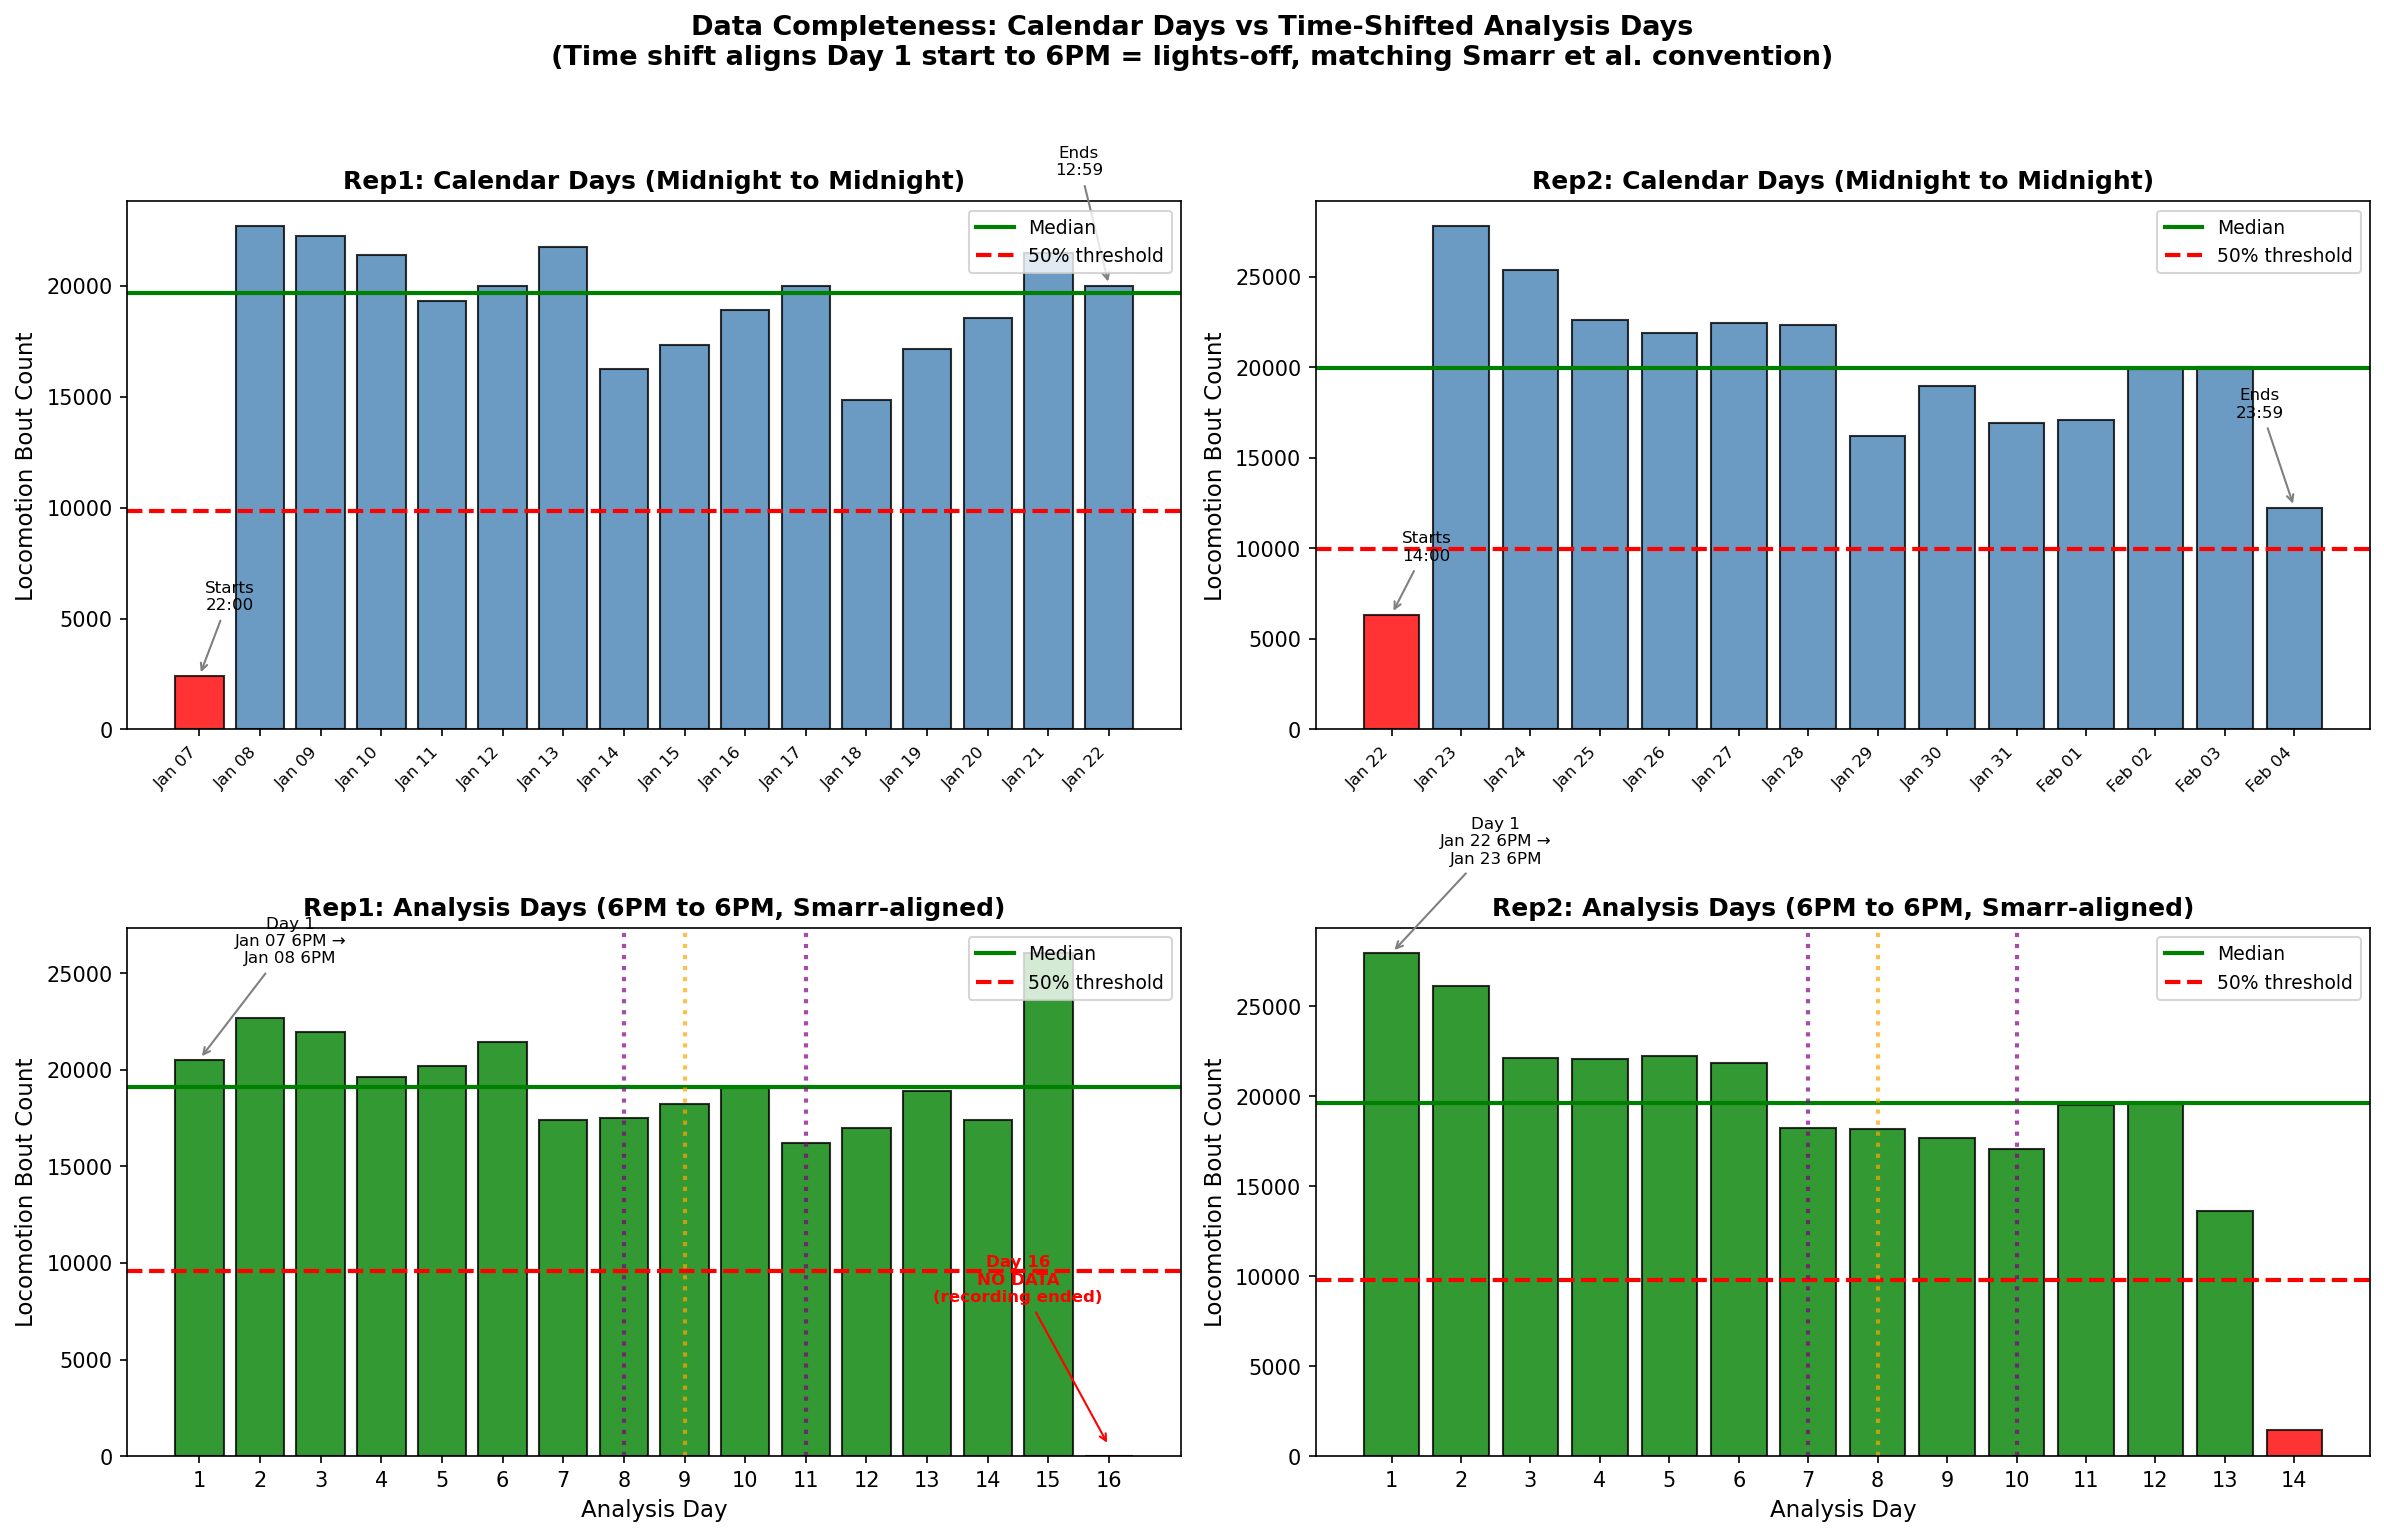


SUMMARY: Calendar Days vs Analysis Days

Rep1:
  Calendar: 2025-01-07 to 2025-01-22
  Analysis Day 1: 2025-01-07 6PM → next day 6PM
  Analysis Day 16: Starts Jan 22 6PM

Rep2:
  Calendar: 2025-01-22 to 2025-02-04
  Analysis Day 1: 2025-01-22 6PM → next day 6PM
  Analysis Day 14: Starts Feb 04 6PM


In [19]:
# =============================================================================
# COMPARE CALENDAR DAYS VS ANALYSIS DAYS (TIME-SHIFTED)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    
    # ----- TOP ROW: Calendar Days (Midnight to Midnight) -----
    ax_cal = axes[0, col]
    
    rep_df['calendar_date'] = rep_df['start_time'].dt.date
    calendar_counts = rep_df.groupby('calendar_date').size()
    calendar_days = list(range(1, len(calendar_counts) + 1))
    calendar_dates = [str(d) for d in calendar_counts.index]
    
    median_cal = calendar_counts.median()
    colors_cal = ['red' if c < median_cal * 0.5 else 'steelblue' for c in calendar_counts.values]
    
    bars = ax_cal.bar(calendar_days, calendar_counts.values, color=colors_cal, edgecolor='black', alpha=0.8)
    ax_cal.axhline(y=median_cal, color='green', linestyle='-', linewidth=2, label='Median')
    ax_cal.axhline(y=median_cal * 0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    
    # Add date labels on x-axis
    ax_cal.set_xticks(calendar_days)
    ax_cal.set_xticklabels([d.strftime('%b %d') for d in calendar_counts.index], rotation=45, ha='right', fontsize=8)
    
    ax_cal.set_ylabel('Locomotion Bout Count', fontsize=11)
    ax_cal.set_title(f'{rep}: Calendar Days (Midnight to Midnight)', fontsize=12, fontweight='bold')
    ax_cal.legend(loc='upper right', fontsize=9)
    
    # Annotate first/last day times
    first_date = calendar_counts.index[0]
    last_date = calendar_counts.index[-1]
    first_day_df = rep_df[rep_df['calendar_date'] == first_date]
    last_day_df = rep_df[rep_df['calendar_date'] == last_date]
    
    ax_cal.annotate(f"Starts\n{first_day_df['start_time'].min().strftime('%H:%M')}", 
                    xy=(1, calendar_counts.iloc[0]), xytext=(1.5, calendar_counts.iloc[0] + 3000),
                    fontsize=8, ha='center', arrowprops=dict(arrowstyle='->', color='gray'))
    ax_cal.annotate(f"Ends\n{last_day_df['start_time'].max().strftime('%H:%M')}", 
                    xy=(len(calendar_days), calendar_counts.iloc[-1]), 
                    xytext=(len(calendar_days) - 0.5, calendar_counts.iloc[-1] + 5000),
                    fontsize=8, ha='center', arrowprops=dict(arrowstyle='->', color='gray'))
    
    # ----- BOTTOM ROW: Analysis Days (6PM to 6PM) -----
    ax_analysis = axes[1, col]
    
    # Calculate shifted start
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)  # 6PM
    
    # Count bouts per analysis day
    analysis_counts = []
    for day in range(1, cfg['n_days'] + 1):
        day_start = shifted_start + pd.Timedelta(days=day-1)
        day_end = shifted_start + pd.Timedelta(days=day)
        day_bouts = rep_df[(rep_df['start_time'] >= day_start) & (rep_df['start_time'] < day_end)]
        analysis_counts.append(len(day_bouts))
    
    analysis_days = list(range(1, cfg['n_days'] + 1))
    median_analysis = np.median([c for c in analysis_counts if c > 0])
    colors_analysis = ['red' if c < median_analysis * 0.5 else 'green' for c in analysis_counts]
    
    ax_analysis.bar(analysis_days, analysis_counts, color=colors_analysis, edgecolor='black', alpha=0.8)
    ax_analysis.axhline(y=median_analysis, color='green', linestyle='-', linewidth=2, label='Median')
    ax_analysis.axhline(y=median_analysis * 0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    
    # Add treatment markers
    ax_analysis.axvline(x=cfg['dose_1_day'], color='purple', linestyle=':', linewidth=2, alpha=0.7)
    ax_analysis.axvline(x=cfg['dose_2_day'], color='purple', linestyle=':', linewidth=2, alpha=0.7)
    ax_analysis.axvline(x=cfg['cage_change_day'], color='orange', linestyle=':', linewidth=2, alpha=0.7)
    
    ax_analysis.set_xlabel('Analysis Day', fontsize=11)
    ax_analysis.set_ylabel('Locomotion Bout Count', fontsize=11)
    ax_analysis.set_title(f'{rep}: Analysis Days (6PM to 6PM, Smarr-aligned)', fontsize=12, fontweight='bold')
    ax_analysis.legend(loc='upper right', fontsize=9)
    ax_analysis.set_xticks(analysis_days)
    
    # Annotate Day 1 and last day
    ax_analysis.annotate(f"Day 1\n{shifted_start.strftime('%b %d')} 6PM →\n{(shifted_start + pd.Timedelta(days=1)).strftime('%b %d')} 6PM", 
                         xy=(1, analysis_counts[0]), xytext=(2.5, analysis_counts[0] + 5000),
                         fontsize=8, ha='center', arrowprops=dict(arrowstyle='->', color='gray'))
    
    if analysis_counts[-1] == 0:
        ax_analysis.annotate(f"Day {cfg['n_days']}\nNO DATA\n(recording ended)", 
                             xy=(cfg['n_days'], 500), xytext=(cfg['n_days'] - 1.5, 8000),
                             fontsize=8, ha='center', color='red', fontweight='bold',
                             arrowprops=dict(arrowstyle='->', color='red'))

# Add overall title
fig.suptitle('Data Completeness: Calendar Days vs Time-Shifted Analysis Days\n' + 
             '(Time shift aligns Day 1 start to 6PM = lights-off, matching Smarr et al. convention)',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('morph2rep_calendar_vs_analysis_days.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY: Calendar Days vs Analysis Days")
print("="*80)
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print(f"  Calendar: {cfg['analysis_start']} to {cfg['analysis_end']}")
    print(f"  Analysis Day 1: {cfg['analysis_start']} 6PM → next day 6PM")
    print(f"  Analysis Day {cfg['n_days']}: Starts {(pd.to_datetime(cfg['analysis_start']) + pd.Timedelta(days=cfg['n_days']-1, hours=12)).strftime('%b %d')} 6PM")

In [20]:
# =============================================================================
# CONFIRM DAY 16 DATA - NO TIME SHIFT (Calendar days: Midnight to Midnight)
# =============================================================================

# Calendar day alignment (NO time shift)
calendar_start = pd.to_datetime("2025-01-07 00:00:00")  # Jan 7, midnight

# Day 16 = Jan 22, midnight to Jan 23, midnight
day_16_start = calendar_start + pd.Timedelta(days=15)  # Jan 22, 00:00
day_16_end = calendar_start + pd.Timedelta(days=16)    # Jan 23, 00:00

print("Day 16 Calendar Window (NO time shift):")
print(f"  Start: {day_16_start}")
print(f"  End:   {day_16_end}")

# Check for bouts in this window
rep1_df = df_loco[df_loco['replicate'] == 'Rep1'].copy()
day_16_bouts = rep1_df[(rep1_df['start_time'] >= day_16_start) & 
                        (rep1_df['start_time'] < day_16_end)]

print(f"\nBouts in Day 16 (Jan 22): {len(day_16_bouts):,}")

if len(day_16_bouts) > 0:
    print(f"\nDay 16 data coverage:")
    print(f"  First bout: {day_16_bouts['start_time'].min()}")
    print(f"  Last bout:  {day_16_bouts['start_time'].max()}")
    hours_covered = (day_16_bouts['start_time'].max() - day_16_start).total_seconds() / 3600
    print(f"  Hours covered: {hours_covered:.1f} / 24")

# Compare Day 15 (Jan 21)
day_15_start = calendar_start + pd.Timedelta(days=14)  # Jan 21, 00:00
day_15_end = calendar_start + pd.Timedelta(days=15)    # Jan 22, 00:00

day_15_bouts = rep1_df[(rep1_df['start_time'] >= day_15_start) & 
                        (rep1_df['start_time'] < day_15_end)]

print(f"\nBouts in Day 15 (Jan 21): {len(day_15_bouts):,}")

Day 16 Calendar Window (NO time shift):
  Start: 2025-01-22 00:00:00
  End:   2025-01-23 00:00:00

Bouts in Day 16 (Jan 22): 20,004

Day 16 data coverage:
  First bout: 2025-01-22 00:00:00
  Last bout:  2025-01-22 12:59:59
  Hours covered: 13.0 / 24

Bouts in Day 15 (Jan 21): 21,463
